In [8]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import math
import pathlib
import pickle
import sys

from itertools import combinations
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats, interp
from scipy.stats import ttest_rel

from sklearn import metrics, neighbors, linear_model, preprocessing, svm
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('poster',font_scale=1)

In [10]:
time.sleep(3600*14)

In [11]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                #print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            #print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        #print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        #np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        #np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        #np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 
                          'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 




def LOSOMultiClass(Data,X,y,groups,model,AUC = True,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','RMS'])
    groupres = {} #results on each group for each model
    
    acc_all=[]; acc_train=[] 
    f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
    auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
    RMS_all = []
    
    clf = model[0][0]; model_name = model[0][1]          
    print('Training %s'%model_name)
    s = 0
    #LOSO CV for current classifier
    for train_index, test_index in subj.split(X, y, groups):
    #leave one in:
        if LOin:
            tridx = train_index.copy()
            train_index = test_index.copy()
            test_index = tridx
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        
        
        
        #Round predicted values for Regression model
#         if model_name == 'Random Forest Regressor':
#             for ypr in ypred:
#                 if ypr < 0:
#                     ypr = 0
#                 elif ypr > 4:
#                     ypr = 4
#                 else:
#                     ypr = round(ypr)
        
        if AUC:
            yscore = clf.predict_proba(Xte)
            if len(np.unique(yte))>1:
                yte_bin = label_binarize(yte, clf.classes_)
                for c in list(range(yte_bin.shape[1]))[::-1]:
                    if not any(yte_bin[:,c]):
                        yte_bin = np.delete(yte_bin,[c],axis=1)
                        yscore = np.delete(yscore,[c],axis=1)
                
                auroc = roc_auc_score(yte_bin,yscore,average='weighted')
                fpr_mean = np.array(range(0,101))/100
                tprs = []
                for i in range(yte_bin.shape[1]):
                    yt = yte_bin[:,i]
                    ys = yscore[:,i]
                    fpr, tpr, thresh = roc_curve(yt,ys)
                    tpr = interp(fpr_mean,fpr,tpr)*np.mean(yt)
                    tprs.append(tpr)

                tpr = sum(tprs)
                fpr = fpr_mean
                
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
                fpr = np.array([])
                tpr = np.array([])

            tpr_all.append(tpr)
            fpr_all.append(fpr)
            auroc_all.append(auroc)
                
            RMS_all.append(auroc)
            
        else:

            RMS=0
            for yp,yt in zip(ypred,y):
                RMS += ((yp - yt)**2)
            RMS = RMS / len(y)
            RMS = math.sqrt(RMS)

            RMS_all.append(RMS)

        groupres[model_name] = {'RMS':RMS_all, 'tpr': tpr_all, 'fpr':fpr_all}

        r = pd.DataFrame({'model':model_name, 'RMS':np.nanmean(RMS_all)},index=[0])
        results = pd.concat((results,r))
        
    return results, groupres

In [12]:
info = ['Subject','Visit','Task','Bradykinesia','Tremor']

featdict_full = {'freq':['Dom_freqX','Pdom_relX','PSD_meanX','PSD_stdX','PSD_skewX','PSD_kurX',
                        'Dom_freqY','Pdom_relY','PSD_meanY','PSD_stdY','PSD_skewY','PSD_kurY',
                        'Dom_freqZ','Pdom_relZ','PSD_meanZ','PSD_stdZ','PSD_skewZ','PSD_kurZ',
                        'Dom_freq_mag','Pdom_rel_mag','PSD_mean_mag','PSD_std_mag','PSD_skew_mag','PSD_kur_mag'],
            'time':['RMSX','RMSY','RMSZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
                    'skewX','skewY','skewZ','kurtX','kurtY','kurtZ',
                   'RMS_mag','range_mag','mean_mag','var_mag','skew_mag','kurt_mag'],
            'entropy':['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'],
            'corr':['xcorr_peakXZ','xcorr_peakYZ','xcor_peakXY','xcorr_lagXZ','xcorr_lagYZ','xcorr_lagXY'],
            'jerk':['jerk_meanX','jerk_stdX','jerk_skewX','jerk_kurX',
                    'jerk_meanY','jerk_stdY','jerk_skewY','jerk_kurY',
                    'jerk_meanZ','jerk_stdZ','jerk_skewZ','jerk_kurZ',
                    'jerk_mean_mag','jerk_std_mag','jerk_skew_mag','jerk_kur_mag']}

featdict_tri = {'freq':['Dom_freqX','Pdom_relX','PSD_meanX','PSD_stdX','PSD_skewX','PSD_kurX',
                        'Dom_freqY','Pdom_relY','PSD_meanY','PSD_stdY','PSD_skewY','PSD_kurY',
                        'Dom_freqZ','Pdom_relZ','PSD_meanZ','PSD_stdZ','PSD_skewZ','PSD_kurZ'],
            'time':['RMSX','RMSY','RMSZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ','skewX','skewY','skewZ','kurtX','kurtY','kurtZ'],
            'entropy':['Sen_X', 'Sen_Y', 'Sen_Z'],
            'corr':['xcorr_peakXZ','xcorr_peakYZ','xcor_peakXY','xcorr_lagXZ','xcorr_lagYZ','xcorr_lagXY'],
            'jerk':['jerk_meanX','jerk_stdX','jerk_skewX','jerk_kurX',
                    'jerk_meanY','jerk_stdY','jerk_skewY','jerk_kurY',
                    'jerk_meanZ','jerk_stdZ','jerk_skewZ','jerk_kurZ']}

featdict_mag = {'freq':['Dom_freq_mag','Pdom_rel_mag','PSD_mean_mag','PSD_std_mag','PSD_skew_mag','PSD_kur_mag'],
            'time':['RMS_mag','range_mag','mean_mag','var_mag','skew_mag','kurt_mag'],
            'entropy':['Sen_mag'],
            'corr':['xcorr_peakXZ','xcorr_peakYZ','xcor_peakXY','xcorr_lagXZ','xcorr_lagYZ','xcorr_lagXY'],
            'jerk':['jerk_mean_mag','jerk_std_mag','jerk_skew_mag','jerk_kur_mag']}

#Accel+Gyro file has features labeled with 'acc' and 'gyr' 
def fix_feature_names(features):
    feats = features.copy()
    if feats[0][-3:] != 'acc':
        featlen = len(feats)
        for f in range(featlen):
            feats.append(feats[f] + ' gyr')
        for f in range(featlen):
            feats[f] = feats[f] + ' acc'
    return feats

In [13]:
# lst = featdict.keys()
# combs = [['mag']]
# for i in range(len(lst)):
#     els = [list(x) for x in combinations(lst, i+1) if 'mag' not in x]
#     combs.extend(els)

# combs

In [14]:
datadict = {'watch':{'Tremor':{},'Bradykinesia':{}},'sensor':{'Tremor':{},'Bradykinesia':{}}}
datadict['watch']['Tremor']['Binary'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Watch Data 30Hz.csv',index_col=0)#.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'])
datadict['watch']['Bradykinesia']['Binary'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Watch Data 30Hz.csv',index_col=0)#.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'])
datadict['sensor']['Tremor']['Binary'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Accel Data 30Hz.csv',index_col=0)#.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'])
datadict['sensor']['Bradykinesia']['Binary'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Accel+Gyro Data 30Hz.csv',index_col=0)#.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc', 'Sen_X gyr', 'Sen_Y gyr', 'Sen_Z gyr', 'Sen_mag gyr'])
datadict['watch']['Tremor']['Multiclass'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Watch Data 30Hz.csv',index_col=0)#.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'])
datadict['watch']['Bradykinesia']['Multiclass'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Watch Data 30Hz.csv',index_col=0)#.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'])
datadict['sensor']['Tremor']['Multiclass'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Accel Data 30Hz.csv',index_col=0)#.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'])
datadict['sensor']['Bradykinesia']['Multiclass'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Accel+Gyro Data 30Hz.csv',index_col=0)#.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc', 'Sen_X gyr', 'Sen_Y gyr', 'Sen_Z gyr', 'Sen_mag gyr'])

In [15]:
datadict['sensor']['Bradykinesia']['Binary']

,Subject,Visit,Task,Bradykinesia,Tremor,RMSX acc,RMSY acc,RMSZ acc,rangeX acc,rangeY acc,...,Dom_freq_mag gyr,Pdom_rel_mag gyr,PSD_mean_mag gyr,PSD_std_mag gyr,PSD_skew_mag gyr,PSD_kur_mag gyr,jerk_mean_mag gyr,jerk_std_mag gyr,jerk_skew_mag gyr,jerk_kur_mag gyr
0,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.001026,0.000732,0.000826,0.077652,0.047792,...,0.199747,0.210169,0.429002,0.983332,4.872550,25.298292,-0.071196,2.665672,-0.176127,2.914705
1,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000817,0.000708,0.000646,0.052163,0.069123,...,0.798989,0.158348,0.450328,1.003282,3.595912,13.092079,-0.035671,1.570365,0.370732,1.053521
2,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000821,0.000695,0.000599,0.066221,0.073316,...,0.399494,0.260404,0.390778,1.115551,4.750249,25.047195,-0.006072,1.226062,0.018525,0.882693
3,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000673,0.000511,0.000540,0.054808,0.036253,...,0.599242,0.137364,0.135641,0.259742,3.041567,9.600950,-0.000953,1.329891,-0.145691,6.417939
4,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000456,0.000351,0.000407,0.031727,0.028231,...,0.199747,0.170720,0.183230,0.368786,3.820675,16.703085,-0.000050,1.077535,0.913476,19.210940
5,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000297,0.000186,0.000229,0.017859,0.012279,...,0.199747,0.168847,0.016082,0.032825,3.883754,16.208982,0.002892,0.405293,0.034616,-0.005801
6,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000447,0.000262,0.000227,0.044505,0.034877,...,0.998736,0.207679,0.012197,0.027170,4.324854,21.979164,0.023804,0.446225,0.537359,1.949249
7,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000549,0.000266,0.000243,0.061209,0.034963,...,0.601156,0.129596,0.076307,0.134789,2.763010,8.392929,-0.001457,0.590419,-2.056699,14.244784
8,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000415,0.000209,0.000250,0.031523,0.012146,...,0.599242,0.230514,0.022578,0.061572,4.557889,21.146555,-0.015260,0.519877,-3.033629,23.081804
9,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000315,0.000201,0.000244,0.018483,0.011479,...,0.599242,0.153202,0.012582,0.023161,4.062674,18.561937,0.005177,0.399096,0.100478,0.443311


In [16]:
#skip this cell and open pkl file

t1 = time.time()
results = {}
for featdict, filename in zip([featdict_full, featdict_tri, featdict_mag],['full', 'tri', 'mag']):
# for featdict, filename in zip([featdict_mag],['mag']):
    
    featdictsensors = {}
    for featgroup in featdict.keys():
        feats = fix_feature_names(featdict[featgroup])
        featdictsensors[featgroup] = feats
    
    lst = featdict.keys()
    combs = []
    for i in range(len(lst)):
        els = [list(x) for x in combinations(lst, i+1)]
        combs.extend(els)
        
    for mode in ['watch','sensor']:
#     for mode in ['sensor']:

        results[mode] = {}

        for symptom in ['Tremor','Bradykinesia']:
#         for symptom in ['Bradykinesia']:

            count = 0
            print(mode + ', ' + symptom)

            results[mode][symptom] = {}

            dataBin = datadict[mode][symptom]['Binary']
            dataMulti = datadict[mode][symptom]['Multiclass']

            results[mode][symptom]['Binary'] = {}
            binary_res_all = pd.DataFrame()
            binary_res_groups = {}

            results[mode][symptom]['Multiclass'] = {}
            multi_res_all = pd.DataFrame()
            multi_res_groups = {}

            for comb in combs:

                count += 1
                print('Combination %d of %d'%(count,len(combs)))

                feat_cols = []
                comb_group = ''

                for features_set in comb:

                    comb_group += features_set[0]
                    if mode == 'sensor' and symptom == 'Bradykinesia':
                        feat_cols = feat_cols + featdictsensors[features_set]
                    else:
                        feat_cols = feat_cols + featdict[features_set]

                DataBin = dataBin[info + feat_cols].copy()
                DataMulti = dataMulti[info + feat_cols].copy()

                DataBin=DataBin[~DataBin[symptom].isnull()] #remove nan rows for current symptom
                for s in DataBin.columns.values[5:]:
                    DataBin.loc[DataBin[s]>np.finfo(np.float32).max,s] = 100
                DataBin=DataBin.reset_index(drop=True) #reset index
                DataMulti=DataMulti[~DataMulti[symptom].isnull()] #remove nan rows for current symptom
                for s in DataMulti.columns.values[5:]:
                    DataMulti.loc[DataMulti[s]>np.finfo(np.float32).max,s] = 100
                DataMulti=DataMulti.reset_index(drop=True) #reset index

                #Binary

                X = DataBin.iloc[:,5:].values
                groups = DataBin.Subject.values
                fnames = DataBin.iloc[:,5:].columns.values

                y = ((DataBin[symptom]>0)).values.astype(int)

                model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
                model_name = ['Random Forest']
                model = list(zip(model,model_name))

                res,res_group = LOSOCV(DataBin,X,y,groups,model)
                res['Combination'] = comb_group
                binary_res_all = pd.concat((binary_res_all,res))
                binary_res_groups[comb_group] = res_group

                #Multiple Classes

                X = DataMulti.iloc[:,5:].values
                groups = DataMulti.Subject.values
                fnames = DataMulti.iloc[:,5:].columns.values

                y = DataMulti[symptom].values.astype(int)

                model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
                model_name = ['Random Forest']
                model = list(zip(model,model_name))

                res,res_group = LOSOMultiClass(DataMulti,X,y,groups,model,True)
                res['Combination'] = comb_group
                multi_res_groups[comb_group] = res_group
                R = pd.DataFrame()
                R['RMS'] = [np.nanmean(multi_res_groups[comb_group][model_name[0]]['RMS'])]
                R['Model'] = ['Random Forest']
                R['Combination'] = [comb_group]
                multi_res_all = pd.concat([multi_res_all,R])

    #             #Regressor

    #             y = Data[symptom].values.astype(int) #target 

    #             model = [RandomForestRegressor(n_estimators=50,random_state=2)]          
    #             model_name = ['Random Forest Regressor']
    #             model = list(zip(model,model_name))

    #             res,res_group = LOSOMultiClass(Data,X,y,groups,model,False)
    #             res['Combination'] = comb_group
    #             regress_res_groups = pd.concat((regress_res_groups,res))
    #             R = pd.DataFrame()
    #             R['RMS'] = [np.nanmean(regress_res_groups[regress_res_groups.Combination==comb_group]['RMS'])]
    #             R['Model'] = ['Random Forest'] 
    #             R['Combination'] = [comb_group]
    #             regress_res_all = pd.concat([regress_res_all,R])

            results[mode][symptom]['Binary']['res_all'] = binary_res_all.reset_index(drop=True)
            results[mode][symptom]['Binary']['res_groups'] = binary_res_groups

            results[mode][symptom]['Multiclass']['res_all'] = multi_res_all.reset_index(drop=True)
            results[mode][symptom]['Multiclass']['res_groups'] = multi_res_groups

    #         results[mode][symptom]['Regressor']['res_all'] = regress_res_all.reset_index(drop=True)
    #         results[mode][symptom]['Regressor']['res_groups'] = regress_res_groups

    f = open('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Results\\FeaturesAnalysisResults_'+filename+'.pkl','wb')
    pickle.dump(results,f)
    f.close()

    print('Elapsed time = %.3f min'%((time.time()-t1)/60))

watch, Tremor
Combination 1 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 2 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 3 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 4 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 5 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 6 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 7 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 8 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 9 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 10 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 11 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 12 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 13 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 14 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 15 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 16 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 17 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 18 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 19 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 20 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 21 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 22 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 23 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 24 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 25 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 26 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 27 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 28 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 29 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 30 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 31 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
watch, Bradykinesia
Combination 1 of 31
Training Random Forest
Training Random Forest
Combination 2 of 31
Training Random Forest
Training Random Forest
Combination 3 of 31
Training Random Forest
Training Random Forest
Combination 4 of 31
Training Random Forest
Training Random Forest
Combination 5 of 31
Training Random Forest
Training Random Forest
Combination 6 of 31
Training Random Forest
Training Random Forest
Combination 7 of 31
Training Random Forest
Training Random Forest
Combination 8 of 31
Training Random Forest
Training Random Forest
Combination 9 of 31
Training Random Forest
Training Random Forest
Combination 10 of 31
Training Random Forest
Training Random Forest
Combination 11 of 31
Training Random Forest
Training Random Forest
Combination 12 of 31
Training Random Forest
Training Random Forest
Combination 13 of 31
Training Random Forest
Training Random Forest
Combination 14 of 31
Training Random Forest
Training Random Forest
Combination 15 of 31
Trainin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 2 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 3 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 4 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 5 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 6 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 7 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 8 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 9 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 10 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 11 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 12 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 13 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 14 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 15 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 16 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 17 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 18 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 19 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 20 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 21 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 22 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 23 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 24 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 25 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 26 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 27 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 28 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 29 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 30 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 31 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
sensor, Bradykinesia
Combination 1 of 31
Training Random Forest
Training Random Forest
Combination 2 of 31
Training Random Forest
Training Random Forest
Combination 3 of 31
Training Random Forest
Training Random Forest
Combination 4 of 31
Training Random Forest
Training Random Forest
Combination 5 of 31
Training Random Forest
Training Random Forest
Combination 6 of 31
Training Random Forest
Training Random Forest
Combination 7 of 31
Training Random Forest
Training Random Forest
Combination 8 of 31
Training Random Forest
Training Random Forest
Combination 9 of 31
Training Random Forest
Training Random Forest
Combination 10 of 31
Training Random Forest
Training Random Forest
Combination 11 of 31
Training Random Forest
Training Random Forest
Combination 12 of 31
Training Random Forest
Training Random Forest
Combination 13 of 31
Training Random Forest
Training Random Forest
Combination 14 of 31
Training Random Forest
Training Random Forest
Combination 15 of 31
Traini

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 2 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 3 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 4 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 5 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 6 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 7 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 8 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 9 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 10 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 11 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 12 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 13 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 14 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 15 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 16 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 17 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 18 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 19 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 20 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 21 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 22 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 23 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 24 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 25 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 26 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 27 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 28 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 29 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 30 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 31 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
watch, Bradykinesia
Combination 1 of 31
Training Random Forest
Training Random Forest
Combination 2 of 31
Training Random Forest
Training Random Forest
Combination 3 of 31
Training Random Forest
Training Random Forest
Combination 4 of 31
Training Random Forest
Training Random Forest
Combination 5 of 31
Training Random Forest
Training Random Forest
Combination 6 of 31
Training Random Forest
Training Random Forest
Combination 7 of 31
Training Random Forest
Training Random Forest
Combination 8 of 31
Training Random Forest
Training Random Forest
Combination 9 of 31
Training Random Forest
Training Random Forest
Combination 10 of 31
Training Random Forest
Training Random Forest
Combination 11 of 31
Training Random Forest
Training Random Forest
Combination 12 of 31
Training Random Forest
Training Random Forest
Combination 13 of 31
Training Random Forest
Training Random Forest
Combination 14 of 31
Training Random Forest
Training Random Forest
Combination 15 of 31
Trainin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 2 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 3 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 4 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 5 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 6 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 7 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 8 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 9 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 10 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 11 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 12 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 13 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 14 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 15 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 16 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 17 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 18 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 19 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 20 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 21 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 22 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 23 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 24 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 25 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 26 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 27 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 28 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 29 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 30 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 31 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
sensor, Bradykinesia
Combination 1 of 31
Training Random Forest
Training Random Forest
Combination 2 of 31
Training Random Forest
Training Random Forest
Combination 3 of 31
Training Random Forest
Training Random Forest
Combination 4 of 31
Training Random Forest
Training Random Forest
Combination 5 of 31
Training Random Forest
Training Random Forest
Combination 6 of 31
Training Random Forest
Training Random Forest
Combination 7 of 31
Training Random Forest
Training Random Forest
Combination 8 of 31
Training Random Forest
Training Random Forest
Combination 9 of 31
Training Random Forest
Training Random Forest
Combination 10 of 31
Training Random Forest
Training Random Forest
Combination 11 of 31
Training Random Forest
Training Random Forest
Combination 12 of 31
Training Random Forest
Training Random Forest
Combination 13 of 31
Training Random Forest
Training Random Forest
Combination 14 of 31
Training Random Forest
Training Random Forest
Combination 15 of 31
Traini

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 2 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 3 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 4 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 5 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 6 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 7 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 8 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 9 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 10 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 11 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 12 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 13 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 14 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 15 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 16 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 17 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 18 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 19 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 20 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 21 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 22 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 23 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 24 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 25 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 26 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 27 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 28 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 29 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 30 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 31 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
watch, Bradykinesia
Combination 1 of 31
Training Random Forest
Training Random Forest
Combination 2 of 31
Training Random Forest
Training Random Forest
Combination 3 of 31
Training Random Forest
Training Random Forest
Combination 4 of 31
Training Random Forest
Training Random Forest
Combination 5 of 31
Training Random Forest
Training Random Forest
Combination 6 of 31
Training Random Forest
Training Random Forest
Combination 7 of 31
Training Random Forest
Training Random Forest
Combination 8 of 31
Training Random Forest
Training Random Forest
Combination 9 of 31
Training Random Forest
Training Random Forest
Combination 10 of 31
Training Random Forest
Training Random Forest
Combination 11 of 31
Training Random Forest
Training Random Forest
Combination 12 of 31
Training Random Forest
Training Random Forest
Combination 13 of 31
Training Random Forest
Training Random Forest
Combination 14 of 31
Training Random Forest
Training Random Forest
Combination 15 of 31
Trainin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 2 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 3 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 4 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 5 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 6 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 7 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 8 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 9 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 10 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 11 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 12 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 13 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 14 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 15 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 16 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 17 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 18 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 19 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 20 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 21 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 22 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 23 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 24 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 25 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 26 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 27 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 28 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 29 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 30 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 31 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
sensor, Bradykinesia
Combination 1 of 31
Training Random Forest
Training Random Forest
Combination 2 of 31
Training Random Forest
Training Random Forest
Combination 3 of 31
Training Random Forest
Training Random Forest
Combination 4 of 31
Training Random Forest
Training Random Forest
Combination 5 of 31
Training Random Forest
Training Random Forest
Combination 6 of 31
Training Random Forest
Training Random Forest
Combination 7 of 31
Training Random Forest
Training Random Forest
Combination 8 of 31
Training Random Forest
Training Random Forest
Combination 9 of 31
Training Random Forest
Training Random Forest
Combination 10 of 31
Training Random Forest
Training Random Forest
Combination 11 of 31
Training Random Forest
Training Random Forest
Combination 12 of 31
Training Random Forest
Training Random Forest
Combination 13 of 31
Training Random Forest
Training Random Forest
Combination 14 of 31
Training Random Forest
Training Random Forest
Combination 15 of 31
Traini

In [22]:
dataMulti.columns

Index(['Subject', 'Visit', 'Task', 'Bradykinesia', 'Tremor', 'RMSX acc',
       'RMSY acc', 'RMSZ acc', 'rangeX acc', 'rangeY acc', 'rangeZ acc',
       'meanX acc', 'meanY acc', 'meanZ acc', 'varX acc', 'varY acc',
       'varZ acc', 'skewX acc', 'skewY acc', 'skewZ acc', 'kurtX acc',
       'kurtY acc', 'kurtZ acc', 'xcor_peakXY acc', 'xcorr_peakXZ acc',
       'xcorr_peakYZ acc', 'xcorr_lagXY acc', 'xcorr_lagXZ acc',
       'xcorr_lagYZ acc', 'Dom_freq acc', 'Pdom_rel acc', 'PSD_mean acc',
       'PSD_std acc', 'PSD_skew acc', 'PSD_kur acc', 'jerk_mean acc',
       'jerk_std acc', 'jerk_skew acc', 'jerk_kur acc', 'Sen_X acc',
       'Sen_Y acc', 'Sen_Z acc', 'RMS_mag acc', 'range_mag acc',
       'mean_mag acc', 'var_mag acc', 'skew_mag acc', 'kurt_mag acc',
       'Sen_mag acc', 'RMSX gyr', 'RMSY gyr', 'RMSZ gyr', 'rangeX gyr',
       'rangeY gyr', 'rangeZ gyr', 'meanX gyr', 'meanY gyr', 'meanZ gyr',
       'varX gyr', 'varY gyr', 'varZ gyr', 'skewX gyr', 'skewY gyr',
       'skewZ

In [35]:
f = open('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Results\\FeaturesAnalysisResults_full.pkl','rb')
full_results = pickle.load(f)
f.close()

In [10]:
T = [0.00101043, 0.00232074, 0.0034716,  0.04128475, 0.0010748,  0.0089197,
 0.00242512, 0.00134522, 0.01359604, 0.00302631, 0.00071365]
TDict = {'t': T[2]+T[7], 'e': T[3]+T[8], 'c': T[4], 'f': T[5]+T[9], 'j': T[6]+T[10]}

In [24]:
D = pd.concat([results['sensor']['Tremor']['Binary']['res_all'].auroc,
           results['sensor']['Tremor']['Multiclass']['res_all'].RMS,
           results['sensor']['Bradykinesia']['Binary']['res_all'].auroc,
           results['sensor']['Bradykinesia']['Multiclass']['res_all'].RMS],axis=1)
D.index = [c for c in results['sensor']['Tremor']['Binary']['res_all'].Combination]
D['Times'] = [sum([TDict[f] for f in g])+T[0]+T[1] for g in D.index]
# D.loc['t','Times'] = D.loc['t','Times']-T[1]
# D.loc['e','Times'] = D.loc['e','Times']-T[1]
# D.loc['te','Times'] = D.loc['te','Times']-T[1]
D.sort_values(by='Times',inplace=True)

In [25]:
print(D)

          auroc       RMS     auroc       RMS     Times
c      0.677787  0.658563  0.613921  0.599839  0.004406
j      0.718676  0.708222  0.636822  0.612382  0.006470
cj     0.717316  0.708564  0.640008  0.618092  0.007545
t      0.733444  0.698966  0.676500  0.641437  0.008148
tc     0.728493  0.694514  0.660611  0.638329  0.009223
tj     0.742699  0.716051  0.672649  0.643343  0.011287
tcj    0.735192  0.720708  0.663004  0.639068  0.012362
f      0.739690  0.723060  0.664997  0.641249  0.015277
fc     0.728098  0.725423  0.655492  0.639801  0.016352
fj     0.745855  0.733126  0.659930  0.636247  0.018416
fcj    0.741954  0.731543  0.660598  0.635158  0.019491
ft     0.744846  0.732771  0.678416  0.644743  0.020094
ftc    0.750046  0.725766  0.667445  0.643903  0.021169
ftj    0.751149  0.727661  0.676597  0.646400  0.023233
ftcj   0.745044  0.722996  0.671386  0.641460  0.024308
e      0.635247  0.616933  0.591598  0.563234  0.058212
ec     0.767394  0.733638  0.651912  0.609085  0

In [31]:
full_dict = {}
full_sem = {}
TB = D.iloc[:,[0,4]]; diff = TB.iloc[:,0].diff()>=0; diff.iloc[0]=True

while not all(diff):
    TB = TB[diff]
    diff = TB.iloc[:,0].diff()>=0; diff.iloc[0]=True
full_dict['TB']=[results['sensor']['Tremor']['Binary']['res_groups'][g]['Random Forest']['auroc'] for g in TB.index]
print(TB.index)
TB.columns = ['AUROC','Computation Time']

TM = D.iloc[:,[1,4]]; diff = TM.iloc[:,0].diff()>=0; diff.iloc[0]=True

while not all(diff):
    TM = TM[diff]
    diff = TM.iloc[:,0].diff()>=0; diff.iloc[0]=True
full_dict['TM']=[results['sensor']['Tremor']['Multiclass']['res_groups'][g]['Random Forest']['RMS'] for g in TM.index]
print(TM.index)
TM.columns = ['AUROC','Computation Time']

BB = D.iloc[:,[2,4]]; diff = BB.iloc[:,0].diff()>=0; diff.iloc[0]=True

while not all(diff):
    BB = BB[diff]
    diff = BB.iloc[:,0].diff()>=0; diff.iloc[0]=True
full_dict['BB']=[results['sensor']['Bradykinesia']['Binary']['res_groups'][g]['Random Forest']['auroc'] for g in BB.index]
print(BB.index)
BB.columns = ['AUROC','Computation Time']

BM = D.iloc[:,[3,4]]; diff = BM.iloc[:,0].diff()>=0; diff.iloc[0]=True

while not all(diff):
    BM = BM[diff]
    diff = BM.iloc[:,0].diff()>=0; diff.iloc[0]=True
full_dict['BM']=[results['sensor']['Bradykinesia']['Multiclass']['res_groups'][g]['Random Forest']['RMS'] for g in BM.index]
print(BM.index)
BM.columns = ['AUROC','Computation Time']

Index(['c', 'j', 't', 'tj', 'fj', 'ftc', 'ftj', 'ec', 'fec', 'fte'], dtype='object')
Index(['c', 'j', 'cj', 'tj', 'tcj', 'f', 'fc', 'fj', 'ec', 'fe', 'fec'], dtype='object')
Index(['c', 'j', 'cj', 't', 'ft', 'tej', 'fte'], dtype='object')
Index(['c', 'j', 'cj', 't', 'tj', 'ft', 'ftj', 'te', 'tej', 'fte'], dtype='object')


In [33]:
def newSelection(mode,symptom,classifier):
    groups = results[mode][symptom][classifier]['res_all']['Combination'].values
    data = results[mode][symptom][classifier]['res_groups']

    done = False
    opt_feat = ''
    current_auc = 0

    AUC = pd.DataFrame()
    if classifier == 'Binary':
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']
    else:
        for g in groups:
            AUC[g] = data[g]['Random Forest']['RMS']

    print('Forward')
    current = 'j'
    for g in D.index.values[1:]:
        auc_group = (AUC[g].mean()-AUC[current].mean())/(AUC[current].mean())
#         auc_sem = stats.sem(AUC[g].values-AUC[current].mean(), nan_policy='omit')
#         p = stats.ttest_rel(AUC[g],AUC[current],nan_policy='omit')
#     #     print(p)
#         if (p[1]<.05) and (p[0]>0):
        if auc_group>.025:
            print(g)
            current=g

    print('Backward')
    current = 'ftecj'
    for g in D.index.values[-2:0:-1]:
        auc_group = (AUC[g].mean()-AUC[current].mean())/(AUC[current].mean())
#         auc_sem = stats.sem(AUC[g].values-AUC[current].mean(), nan_policy='omit')
#         p = stats.ttest_rel(AUC[g],AUC[current],nan_policy='omit')
# #         print(p)
#         if (p[1]>.05) or (p[0]>0):
#             print(g)
#             if p[0]>0:
#                 current = g
        if auc_group>-.025:
            print(g)
            if auc_group>0:
                current = g

In [ ]:
newSelection('sensor','Tremor','Binary')

In [14]:
newSelection('sensor','Tremor','Multiclass')

Forward
fj
fe
Backward
ftej
ftec
fte
fecj
fej
fec
fe


In [15]:
newSelection('sensor','Bradykinesia','Binary')

Forward
t
Backward
ftej
ftec
fte
fej
fec
fe
tecj
tej
tec
te
ftcj
ftj
ftc
ft
f
tj
t


In [16]:
newSelection('sensor','Bradykinesia','Multiclass')

Forward
t
Backward
ftej
ftec
fte
fecj
fej
fe
tecj
tej
tec
te
ftcj
ftj
ftc
ft
fc
f
tcj
tj
t


In [17]:
groups = results['sensor']['Tremor']['Binary']['res_all']['Combination'].values

In [18]:
D = pd.DataFrame(data = np.vstack([results['sensor']['Tremor']['Binary']['res_groups'][g]['Random Forest']['auroc']
                                   for g in TB.index]).transpose(), 
                 columns = TB.index)
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

NameError: name 'rmANOVA' is not defined

In [431]:
D

,c,j,t,tj,fj,ftc,ftj,ec,fec,fte
0,0.540559,0.645112,0.700145,0.678503,0.666341,0.643422,0.665040,0.711578,0.687833,0.716828
1,0.703275,0.708934,0.695778,0.671430,0.699821,0.695747,0.693024,0.750383,0.751955,0.718036
2,0.776192,0.794730,0.829809,0.822893,0.825892,0.830449,0.832444,0.781923,0.830532,0.827025
3,0.774920,0.730124,0.780494,0.752378,0.763425,0.817256,0.780229,0.765521,0.781359,0.775985
4,0.622773,0.651382,0.659863,0.709270,0.705573,0.685148,0.700225,0.695268,0.710333,0.716268
5,0.657834,0.651430,0.651740,0.720816,0.738700,0.718853,0.734743,0.698606,0.741036,0.741211
6,0.807765,0.857506,0.866815,0.916656,0.919994,0.914848,0.928536,0.937283,0.926099,0.919898
7,0.839209,0.882076,0.871592,0.911244,0.905821,0.905251,0.912433,0.910381,0.899225,0.908269
8,0.777288,0.837103,0.772900,0.831114,0.873004,0.850362,0.858910,0.817162,0.875561,0.870285
10,0.281722,0.241344,0.218233,0.244697,0.267429,0.252006,0.256988,0.402355,0.350083,0.316976


In [432]:
HBCorrections(D,[('fte','c'),('fte','j'),('fte','t'),('fte','tj'),('fte','fj'),('fte','ftc'),('fte','ftj'),('fte','ec'),
                 ('fte','fec')])

fte+j        0.000	0.006	Reject
fte+c        0.001	0.006	Reject
fte+t        0.011	0.007	Accept
fte+tj       0.013	0.008	Accept
fte+ftc      0.036	0.010	Accept
fte+ftj      0.044	0.013	Accept
fte+fj       0.062	0.017	Accept
fte+fec      0.712	0.025	Accept
fte+ec       0.775	0.050	Accept


In [442]:
TB

,AUROC,Computation Time
c,0.677787,0.004406
j,0.718676,0.006470
t,0.733444,0.008148
tj,0.742699,0.011287
fj,0.745855,0.018416
ftc,0.750046,0.021169
ftj,0.751149,0.023233
ec,0.767394,0.059287
fec,0.768393,0.071233
fte,0.771194,0.074975


In [433]:
D = pd.DataFrame(data = np.vstack([results['sensor']['Tremor']['Multiclass']['res_groups'][g]['Random Forest']['RMS']
                                   for g in TM.index]).transpose(), 
                 columns = TM.index)
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(5.673664270033726, 8.173418748729705e-07)

In [434]:
D

,c,j,cj,tj,tcj,f,fc,fj,ec,fe,fec
0,0.535544,0.654981,0.631153,0.670795,0.681132,0.623808,0.603149,0.656691,0.695469,0.715422,0.709362
1,0.697123,0.682203,0.693160,0.673571,0.655585,0.708570,0.718415,0.679462,0.729471,0.742457,0.743993
2,0.786461,0.806255,0.806855,0.833986,0.820871,0.830914,0.830120,0.834310,0.789802,0.819001,0.828618
3,0.786374,0.748657,0.718334,0.760622,0.756805,0.783048,0.803957,0.759111,0.741132,0.774977,0.788441
4,0.600045,0.633614,0.684703,0.692021,0.698541,0.670003,0.689518,0.677492,0.694124,0.698994,0.702684
5,0.629464,0.637566,0.664262,0.676114,0.685682,0.689104,0.695484,0.704542,0.668834,0.726145,0.716353
6,0.814093,0.855862,0.913856,0.925725,0.924243,0.887825,0.909611,0.925017,0.928199,0.924917,0.919313
7,0.849854,0.898826,0.902195,0.901450,0.897965,0.891982,0.883348,0.916471,0.901579,0.896468,0.904662
8,0.666182,0.723210,0.747473,0.711084,0.714359,0.778687,0.781795,0.786146,0.708927,0.782628,0.775892
10,0.330657,0.279105,0.288111,0.305420,0.297944,0.344751,0.345731,0.304586,0.407394,0.413459,0.404874


In [435]:
HBCorrections(D,[('fec','c'),('fec','j'),('fec','cj'),('fec','tj'),('fec','tcj'),('fec','f'),('fec','fc'),
                 ('fec','fj'),('fec','ec'),('fec','fe')])

fec+c        0.000	0.005	Reject
fec+cj       0.001	0.006	Reject
fec+tj       0.003	0.006	Reject
fec+f        0.004	0.007	Reject
fec+tcj      0.023	0.008	Accept
fec+fc       0.027	0.010	Accept
fec+j        0.046	0.013	Accept
fec+fj       0.088	0.017	Accept
fec+ec       0.223	0.025	Accept
fec+fe       0.932	0.050	Accept


In [443]:
TM

,AUROC,Computation Time
c,0.658563,0.004406
j,0.708222,0.006470
cj,0.708564,0.007545
tj,0.716051,0.011287
tcj,0.720708,0.012362
f,0.723060,0.015277
fc,0.725423,0.016352
fj,0.733126,0.018416
ec,0.733638,0.059287
fe,0.752544,0.070158


In [436]:
D = pd.DataFrame(data = np.vstack([results['sensor']['Bradykinesia']['Binary']['res_groups'][g]['Random Forest']['auroc']
                                   for g in BB.index]).transpose(), 
                 columns = BB.index)
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(6.745346795400691, 1.0646121454241791e-05)

In [437]:
D

,c,j,cj,t,ft,tej,fte
0,0.630910,0.603709,0.607244,0.709497,0.690381,0.683059,0.714586
1,0.746563,0.765509,0.768904,0.807453,0.808607,0.796664,0.803708
2,0.796909,0.770538,0.787212,0.817423,0.832656,0.785031,0.828499
3,0.511041,0.637729,0.622395,0.636593,0.613004,0.602161,0.609792
4,0.749990,0.750274,0.758364,0.789020,0.776772,0.779987,0.767576
5,0.662672,0.659417,0.675970,0.647577,0.668756,0.674183,0.645811
6,0.628259,0.658315,0.680302,0.794470,0.791997,0.787599,0.782924
7,0.542924,0.634567,0.563192,0.637069,0.678041,0.695701,0.679356
8,0.437075,0.563974,0.538444,0.534220,0.506012,0.524916,0.489412
9,0.811496,0.639598,0.738265,0.785217,0.776770,0.811068,0.804990


In [438]:
HBCorrections(D,[('fte','c'),('fte','j'),('fte','cj'),('fte','t'),('fte','ft'),('fte','tej')])

fte+c        0.001	0.008	Reject
fte+cj       0.019	0.010	Accept
fte+j        0.038	0.013	Accept
fte+t        0.624	0.017	Accept
fte+ft       0.703	0.025	Accept
fte+tej      0.776	0.050	Accept


In [444]:
BB

,AUROC,Computation Time
c,0.613921,0.004406
j,0.636822,0.006470
cj,0.640008,0.007545
t,0.676500,0.008148
ft,0.678416,0.020094
tej,0.679242,0.066168
fte,0.681355,0.074975


In [439]:
D = pd.DataFrame(data = np.vstack([results['sensor']['Bradykinesia']['Multiclass']['res_groups'][g]['Random Forest']['RMS']
                                   for g in BM.index]).transpose(), 
                 columns = BM.index)
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(6.164154428669234, 5.624800994910438e-07)

In [440]:
D

,c,j,cj,t,tj,ft,ftj,te,tej,fte
0,0.634668,0.620753,0.628057,0.735366,0.661617,0.724042,0.718552,0.708859,0.697020,0.706838
1,0.676694,0.709418,0.664576,0.680123,0.684853,0.672737,0.668988,0.688557,0.679199,0.701328
2,0.756802,0.740284,0.770561,0.729676,0.734776,0.735558,0.739346,0.727133,0.748885,0.736290
3,0.534139,0.687053,0.656792,0.633273,0.666435,0.663739,0.648539,0.651136,0.672374,0.644907
4,0.646477,0.637127,0.661959,0.693365,0.690267,0.706126,0.693995,0.699944,0.702412,0.697554
5,0.586411,0.617517,0.621677,0.608561,0.625094,0.620344,0.611182,0.598009,0.607932,0.621174
6,0.666476,0.649920,0.715613,0.773537,0.767145,0.758306,0.766069,0.768157,0.760670,0.767483
7,0.548297,0.588508,0.551206,0.572896,0.587235,0.576363,0.607982,0.617548,0.613192,0.627341
8,0.466951,0.526781,0.488121,0.523898,0.525133,0.495005,0.516497,0.506231,0.514781,0.510647
9,0.787620,0.628335,0.743101,0.775417,0.800806,0.779252,0.750994,0.814357,0.810234,0.804438


In [441]:
HBCorrections(D,[('fte','c'),('fte','j'),('fte','cj'),('fte','t'),('fte','tj'),('fte','ft'),('fte','ftj'),
                 ('fte','te'),('fte','tej')])

fte+c        0.000	0.006	Reject
fte+cj       0.002	0.006	Reject
fte+j        0.024	0.007	Accept
fte+tj       0.062	0.008	Accept
fte+t        0.077	0.010	Accept
fte+ft       0.077	0.013	Accept
fte+ftj      0.110	0.017	Accept
fte+te       0.116	0.025	Accept
fte+tej      0.323	0.050	Accept


In [445]:
BM

,AUROC,Computation Time
c,0.599839,0.004406
j,0.612382,0.006470
cj,0.618092,0.007545
t,0.641437,0.008148
tj,0.643343,0.011287
ft,0.644743,0.020094
ftj,0.646400,0.023233
te,0.648961,0.063029
tej,0.650394,0.066168
fte,0.655225,0.074975


In [212]:
TB_full = TB
TM_full = TM
BB_full = BB
BM_full = BM

In [36]:
f = open('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Results\\FeaturesAnalysisResults_mag.pkl','rb')
results = pickle.load(f)
f.close()

In [45]:
PairedT(results['sensor']['Tremor']['Binary']['res_groups']['ftej']['Random Forest']['auroc'],
        full_results['sensor']['Tremor']['Binary']['res_groups']['fte']['Random Forest']['auroc'])

Ttest_relResult(statistic=-0.5159306302476292, pvalue=0.616114498495975)

In [47]:
PairedT(results['sensor']['Tremor']['Multiclass']['res_groups']['ftej']['Random Forest']['RMS'],
        full_results['sensor']['Tremor']['Multiclass']['res_groups']['fec']['Random Forest']['RMS'])

Ttest_relResult(statistic=-1.9011725827679722, pvalue=0.08378398691865194)

In [48]:
PairedT(results['sensor']['Bradykinesia']['Binary']['res_groups']['ftj']['Random Forest']['auroc'],
        full_results['sensor']['Bradykinesia']['Binary']['res_groups']['fte']['Random Forest']['auroc'])

Ttest_relResult(statistic=-0.09456892801225818, pvalue=0.9262179970788524)

In [49]:
PairedT(results['sensor']['Bradykinesia']['Multiclass']['res_groups']['tej']['Random Forest']['RMS'],
        full_results['sensor']['Bradykinesia']['Multiclass']['res_groups']['fte']['Random Forest']['RMS'])

Ttest_relResult(statistic=-0.8660687646632126, pvalue=0.4034364048724157)

In [447]:
T = [0.00101043, 0.00232074, 0.0034716,  0.04128475, 0.0010748,  0.0089197,
 0.00242512, 0.00134522, 0.01359604, 0.00302631, 0.00071365]
TDict = {'t': T[7], 'e': T[8], 'c': T[4], 'f': T[9], 'j': T[10]}

In [448]:
D = pd.concat([results['sensor']['Tremor']['Binary']['res_all'].auroc,
           results['sensor']['Tremor']['Multiclass']['res_all'].RMS,
           results['sensor']['Bradykinesia']['Binary']['res_all'].auroc,
           results['sensor']['Bradykinesia']['Multiclass']['res_all'].RMS],axis=1)
D.index = [c for c in results['sensor']['Tremor']['Binary']['res_all'].Combination]
D['Times'] = [sum([TDict[f] for f in g])+T[0]+T[1] for g in D.index]
# D.loc['t','Times'] = D.loc['t','Times']-T[1]
# D.loc['e','Times'] = D.loc['e','Times']-T[1]
# D.loc['te','Times'] = D.loc['te','Times']-T[1]
D.sort_values(by='Times',inplace=True)

In [449]:
diff

c      True
j      True
cj     True
t      True
tj     True
ft     True
ftj    True
te     True
tej    True
fte    True
Name: RMS, dtype: bool

In [450]:
mag_dict = {}
mag_sem={}
TB = D.iloc[:,[0,4]]; diff = TB.iloc[:,0].diff()>=0; diff.iloc[0]=True
mag_sem['TB'] = np.mean(stats.sem([results['sensor']['Tremor']['Binary']['res_groups'][g]['Random Forest']['auroc'] 
                                   for g in TB.index],nan_policy='omit'))
while not all(diff):
    TB = TB[diff]
    diff = TB.iloc[:,0].diff()>=0; diff.iloc[0]=True
mag_dict['TB']=[results['sensor']['Tremor']['Binary']['res_groups'][g]['Random Forest']['auroc'] for g in TB.index]
print(TB.index)
TB.columns = ['AUROC','Computation Time']

TM = D.iloc[:,[1,4]]; diff = TM.iloc[:,0].diff()>=0; diff.iloc[0]=True
mag_sem['TM'] = np.mean(stats.sem([results['sensor']['Tremor']['Multiclass']['res_groups'][g]['Random Forest']['RMS'] 
                                   for g in TM.index],nan_policy='omit'))
while not all(diff):
    TM = TM[diff]
    diff = TM.iloc[:,0].diff()>=0; diff.iloc[0]=True
mag_dict['TM']=[results['sensor']['Tremor']['Multiclass']['res_groups'][g]['Random Forest']['RMS'] for g in TM.index]
print(TM.index)
TM.columns = ['AUROC','Computation Time']

BB = D.iloc[:,[2,4]]; diff = BB.iloc[:,0].diff()>=0; diff.iloc[0]=True
mag_sem['BB'] = np.mean(stats.sem([results['sensor']['Bradykinesia']['Binary']['res_groups'][g]['Random Forest']['auroc'] 
                                   for g in BB.index],nan_policy='omit'))
while not all(diff):
    BB = BB[diff]
    diff = BB.iloc[:,0].diff()>=0; diff.iloc[0]=True
mag_dict['BB']=[results['sensor']['Bradykinesia']['Binary']['res_groups'][g]['Random Forest']['auroc'] for g in BB.index]
print(BB.index)
BB.columns = ['AUROC','Computation Time']

BM = D.iloc[:,[3,4]]; diff = BM.iloc[:,0].diff()>=0; diff.iloc[0]=True
mag_sem['BM'] = np.mean(stats.sem([results['sensor']['Bradykinesia']['Multiclass']['res_groups'][g]['Random Forest']['RMS'] 
                                   for g in BM.index],nan_policy='omit'))
while not all(diff):
    BM = BM[diff]
    diff = BM.iloc[:,0].diff()>=0; diff.iloc[0]=True
mag_dict['BM']=[results['sensor']['Bradykinesia']['Multiclass']['res_groups'][g]['Random Forest']['RMS'] for g in BM.index]
print(BM.index)
BM.columns = ['AUROC','Computation Time']

Index(['j', 'cj', 'tj', 'fj', 'te', 'ecj', 'tej', 'ftej'], dtype='object')
Index(['j', 'cj', 'tj', 'fj', 'ecj', 'tej', 'fej', 'ftej'], dtype='object')
Index(['j', 't', 'tj', 'ftj'], dtype='object')
Index(['j', 't', 'tj', 'fj', 'ftj', 'tej'], dtype='object')


In [451]:
mag_sem['TB']

0.011955763264937164

In [218]:
TB+(1.98*mag_sem['TB'])

Times
0.004045    0.710726
0.005120    0.738154
0.005390    0.749472
0.007071    0.758881
0.018272    0.764459
0.018716    0.765089
0.018986    0.779036
0.022012    0.783689
Name: auroc, dtype: float64

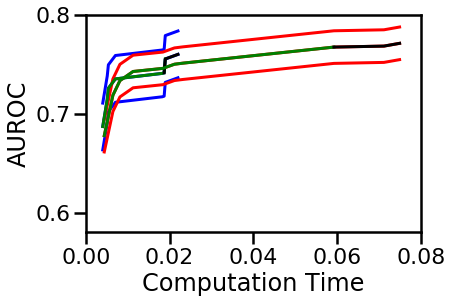

In [250]:
# ax = sns.tsplot(pd.DataFrame(mag_dict['TB']).transpose().dropna().values,time=TB.index)
# sns.tsplot(pd.DataFrame(full_dict['TB']).transpose().dropna().values,time=TB_full.index,color='r')

ax = sns.lineplot(data=TB,color='b')
sns.lineplot(data=TB+(1.98*mag_sem['TB']),color='b');sns.lineplot(data=TB-(1.98*mag_sem['TB']),color='b')
sns.lineplot(data=TB_full,color='r')
sns.lineplot(data=TB_full+(1.98*full_sem['TB']),color='r');sns.lineplot(data=TB_full-(1.98*full_sem['TB']),color='r')


TB.iloc[:7].plot(color='g');TB.iloc[5:].plot(color='k')
TB_full.iloc[:-2].plot(color='g');TB_full.iloc[-3:].plot(color='k')
plt.ylim([.58,.8])
plt.xlim([0,.08])
ax.set_xlabel('Computation Time')
ax.set_ylabel('AUROC')
plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\Features_TremorBinary.svg')

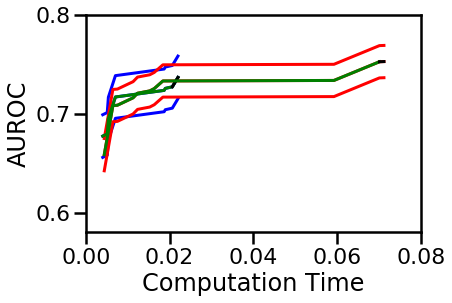

In [251]:
# ax = sns.tsplot(pd.DataFrame(mag_dict['TM']).transpose().dropna().values,time=TM.index)
# sns.tsplot(pd.DataFrame(full_dict['TM']).transpose().dropna().values,time=TM_full.index,color='r')

ax = sns.lineplot(data=TM,color='b')
sns.lineplot(data=TM+(1.98*mag_sem['TM']),color='b');sns.lineplot(data=TM-(1.98*mag_sem['TM']),color='b')
sns.lineplot(data=TM_full,color='r')
sns.lineplot(data=TM_full+(1.98*full_sem['TM']),color='r');sns.lineplot(data=TM_full-(1.98*full_sem['TM']),color='r')

TM.iloc[:].plot(color='g');TM.iloc[-2:].plot(color='k')
TM_full.iloc[:-1].plot(color='g');TM_full.iloc[-2:].plot(color='k')
plt.ylim([.58,.8])
plt.xlim([0,.08])
ax.set_xlabel('Computation Time')
ax.set_ylabel('AUROC')
plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\Features_TremorMulti.svg')

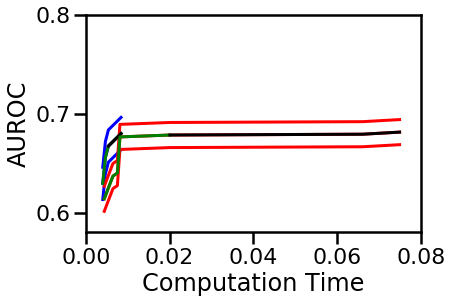

In [252]:
# ax = sns.tsplot(pd.DataFrame(mag_dict['BB']).transpose().dropna().values,time=BB.index)
# sns.tsplot(pd.DataFrame(full_dict['BB']).transpose().dropna().values,time=BB_full.index,color='r')

ax = sns.lineplot(data=BB,color='b')
sns.lineplot(data=BB+(1.98*mag_sem['BB']),color='b');sns.lineplot(data=BB-(1.98*mag_sem['BB']),color='b')
sns.lineplot(data=BB_full,color='r')
sns.lineplot(data=BB_full+(1.98*full_sem['BB']),color='r');sns.lineplot(data=BB_full-(1.98*full_sem['BB']),color='r')

BB.iloc[:].plot(color='g');BB.iloc[-2:].plot(color='k')
BB_full.iloc[:5].plot(color='g');BB_full.iloc[4:].plot(color='k')
plt.ylim([.58,.8])
plt.xlim([0,.08])
ax.set_xlabel('Computation Time')
ax.set_ylabel('AUROC')
plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\Features_BradyBinary.svg')

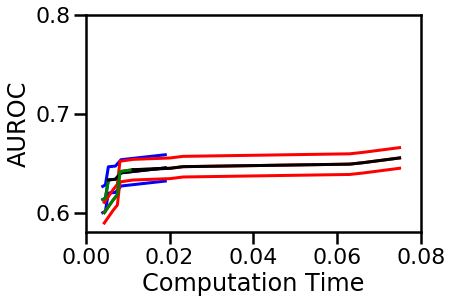

In [253]:
# ax = sns.tsplot(pd.DataFrame(mag_dict['BM']).transpose().dropna().values,time=BM.index)
# sns.tsplot(pd.DataFrame(full_dict['BM']).transpose().dropna().values,time=BM_full.index,color='r')

ax = sns.lineplot(data=BM,color='b')
sns.lineplot(data=BM+(1.98*mag_sem['BM']),color='b');sns.lineplot(data=BM-(1.98*mag_sem['BM']),color='b')
sns.lineplot(data=BM_full,color='r')
sns.lineplot(data=BM_full+(1.98*full_sem['BM']),color='r');sns.lineplot(data=BM_full-(1.98*full_sem['BM']),color='r')

BM.iloc[:3].plot(color='g');BM.iloc[2:].plot(color='k')
BM_full.iloc[:5].plot(color='g');BM_full.iloc[4:].plot(color='k')
plt.ylim([.58,.8])
plt.xlim([0,.08])
ax.set_xlabel('Computation Time')
ax.set_ylabel('AUROC')
plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\Features_BradyMulti.svg')

In [86]:
pd.DataFrame(full_dict['TB']).transpose().dropna().values

array([[0.54055931, 0.6451121 , 0.70014473, 0.67850274, 0.66634126,
        0.64342192, 0.66503963, 0.71157769, 0.68783269, 0.71682791],
       [0.70327462, 0.70893401, 0.69577811, 0.6714296 , 0.69982054,
        0.69574722, 0.69302438, 0.750383  , 0.75195491, 0.7180359 ],
       [0.77619157, 0.79472965, 0.82980859, 0.82289341, 0.82589174,
        0.8304493 , 0.83244401, 0.78192293, 0.83053189, 0.8270255 ],
       [0.77491995, 0.73012407, 0.78049369, 0.75237781, 0.76342523,
        0.81725563, 0.78022884, 0.76552053, 0.78135889, 0.77598526],
       [0.62277256, 0.65138181, 0.65986314, 0.70927014, 0.70557345,
        0.68514816, 0.70022495, 0.69526806, 0.71033307, 0.7162675 ],
       [0.65783407, 0.65143012, 0.65173967, 0.72081614, 0.73869991,
        0.71885346, 0.73474349, 0.69860649, 0.74103648, 0.74121067],
       [0.80776475, 0.85750598, 0.86681501, 0.91665625, 0.919994  ,
        0.91484778, 0.92853631, 0.9372828 , 0.92609862, 0.91989816],
       [0.83920904, 0.88207629, 0.8715922

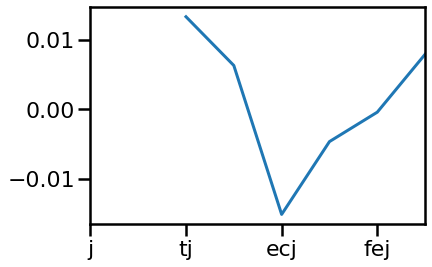

In [406]:
TM.iloc[:,0].diff().diff().plot()

In [37]:
def PairedT(A,B):
    A = np.array(A); B = np.array(B)
    inds = np.isnan(A) | np.isnan(B)
    inds = np.array(~inds)
    return ttest_rel(A[inds],B[inds])

def rmANOVA(df,columns):
    grand_mean = np.mean(df[columns].mean())
    sub_means = np.mean(df[columns],axis=1)
    col_means = np.mean(df[columns],axis=0)
    n = len(df)
    k = len(columns)
    dftotal = n*k - 1
    dfbw = k - 1
    dfsbj = n - 1
    dfw = dftotal - dfbw
    dferror = dfw - dfsbj
    SSbetween = sum(n*[(m-grand_mean)**2 for m in col_means])
    SSwithin = np.nansum(np.nansum([(df[col] - col_means[col])**2 for i,col in enumerate(df[columns])]))
    SSsubject = sum(k*[(m - grand_mean)**2 for m in sub_means])
    SSerror = SSwithin - SSsubject
    SStotal = SSbetween + SSwithin
    msbetween = SSbetween/dfbw
    mserror = SSerror/dferror
    F = msbetween/mserror
    return F,stats.f.sf(F,dfbw,dferror)

def HBCorrections(df,comps,target=.05):
    res = []
    for pair in comps:
        p = PairedT(df[pair[0]].values, df[pair[1]].values)[1]
        res.append((p,str(pair[0])+'+'+str(pair[1])))
    
    res = sorted(res)
    dec = 'Reject'
    for r,i in zip(res,range(1,len(res)+1)):
        thresh = target/(len(res)-i+1)
        if r[0]<thresh:
            dec = 'Reject'
        else:
            dec = 'Accept'
        print('%s%.3f\t%.3f\t%s'%(r[1]+' '*(13-len(r[1])),r[0],thresh,dec))

In [372]:
groups = results['sensor']['Tremor']['Binary']['res_all']['Combination'].values

In [411]:
D = pd.DataFrame(data = np.vstack([results['sensor']['Tremor']['Binary']['res_groups'][g]['Random Forest']['auroc']
                                   for g in TB.index]).transpose(), 
                 columns = TB.index)
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(2.205735551147268, 0.04270142016540132)

In [412]:
D

,j,cj,tj,fj,te,ecj,tej,ftej
0,0.614937,0.593615,0.685516,0.683277,0.715084,0.610264,0.717697,0.732423
1,0.729226,0.743293,0.750069,0.728488,0.720353,0.748516,0.757484,0.754537
2,0.772850,0.813183,0.817267,0.801865,0.799302,0.817685,0.826728,0.823927
3,0.697776,0.783442,0.671491,0.739624,0.708806,0.782613,0.741242,0.723279
4,0.606653,0.691611,0.689095,0.660801,0.678525,0.679190,0.705297,0.710380
5,0.618106,0.692753,0.708515,0.683412,0.682581,0.686709,0.711488,0.711804
6,0.821274,0.929578,0.912523,0.913456,0.870361,0.946050,0.924707,0.926240
7,0.857578,0.907480,0.893987,0.906299,0.867148,0.903247,0.894022,0.899061
8,0.777309,0.857311,0.830936,0.836815,0.765254,0.865079,0.827479,0.835948
10,0.419697,0.324678,0.461256,0.462918,0.438123,0.342238,0.475071,0.466006


In [414]:
HBCorrections(D,[('ftej','j'),('ftej','cj'),('ftej','tj'),('ftej','fj'),('ftej','te'),('ftej','ecj'),('ftej','tej')])

ftej+j       0.001	0.007	Reject
ftej+fj      0.012	0.008	Accept
ftej+tj      0.109	0.010	Accept
ftej+cj      0.142	0.013	Accept
ftej+ecj     0.264	0.017	Accept
ftej+te      0.296	0.025	Accept
ftej+tej     0.347	0.050	Accept


In [453]:
TB

,AUROC,Computation Time
j,0.687054,0.004045
cj,0.714482,0.005120
tj,0.725800,0.005390
fj,0.735208,0.007071
te,0.740787,0.018272
ecj,0.741417,0.018716
tej,0.755363,0.018986
ftej,0.760017,0.022012


In [415]:
D = pd.DataFrame(data = np.vstack([results['sensor']['Tremor']['Multiclass']['res_groups'][g]['Random Forest']['RMS']
                                   for g in TM.index]).transpose(), 
                 columns = TM.index)
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(2.21164736537815, 0.04217026616743961)

In [416]:
D

,j,cj,tj,fj,ecj,tej,fej,ftej
0,0.638945,0.558037,0.696454,0.691814,0.609880,0.710598,0.712372,0.731385
1,0.707959,0.737495,0.733254,0.709770,0.741099,0.727287,0.723360,0.737080
2,0.754467,0.807305,0.810734,0.801824,0.815541,0.831875,0.823986,0.830099
3,0.699781,0.764581,0.659063,0.729340,0.785034,0.716358,0.740345,0.727601
4,0.592161,0.684413,0.673203,0.625925,0.688776,0.675887,0.641993,0.681155
5,0.606044,0.650204,0.680166,0.655602,0.657399,0.684628,0.652733,0.678886
6,0.806292,0.917101,0.901710,0.903420,0.937972,0.910874,0.916198,0.928046
7,0.861771,0.894596,0.888437,0.902392,0.917462,0.898151,0.895369,0.890445
8,0.679522,0.741504,0.718413,0.727744,0.744568,0.723614,0.723523,0.736267
10,0.436734,0.333557,0.449337,0.454270,0.361019,0.464938,0.459974,0.439202


In [417]:
HBCorrections(D,[('ftej','j'),('ftej','cj'),('ftej','tj'),('ftej','fj'),('ftej','ecj'),('ftej','tej'),('ftej','fej')])

ftej+j       0.000	0.007	Reject
ftej+fj      0.008	0.008	Accept
ftej+fej     0.070	0.010	Accept
ftej+cj      0.127	0.013	Accept
ftej+tj      0.148	0.017	Accept
ftej+tej     0.209	0.025	Accept
ftej+ecj     0.356	0.050	Accept


In [452]:
TM

,AUROC,Computation Time
j,0.677358,0.004045
cj,0.679590,0.005120
tj,0.695111,0.005390
fj,0.716914,0.007071
ecj,0.723592,0.018716
tej,0.725611,0.018986
fej,0.727204,0.020667
ftej,0.736695,0.022012


In [418]:
D = pd.DataFrame(data = np.vstack([results['sensor']['Bradykinesia']['Binary']['res_groups'][g]['Random Forest']['auroc']
                                   for g in BB.index]).transpose(), 
                 columns = BB.index)
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(4.590320516428753, 0.008038544698277292)

In [419]:
D

,j,t,tj,ftj
0,0.677966,0.742892,0.692622,0.758734
1,0.813585,0.784704,0.779585,0.771324
2,0.762628,0.801316,0.819509,0.837538
3,0.617464,0.706016,0.678608,0.693289
4,0.671466,0.706213,0.707782,0.715481
5,0.694350,0.669780,0.648769,0.627650
6,0.650824,0.693355,0.717207,0.758485
7,0.613090,0.515263,0.576020,0.632988
8,0.554008,0.492925,0.521748,0.516351
9,0.600388,0.639448,0.709744,0.702198


In [420]:
HBCorrections(D,[('ftj','j'),('ftj','t'),('ftj','tj')])

ftj+j        0.015	0.017	Reject
ftj+t        0.070	0.025	Accept
ftj+tj       0.113	0.050	Accept


In [454]:
BB

,AUROC,Computation Time
j,0.629493,0.004045
t,0.655542,0.004676
tj,0.667254,0.005390
ftj,0.679903,0.008416


In [456]:
D = pd.DataFrame(data = np.vstack([results['sensor']['Bradykinesia']['Multiclass']['res_groups'][g]['Random Forest']['RMS']
                                   for g in BM.index]).transpose(), 
                 columns = BM.index)
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(2.4340140419839775, 0.04484837625888259)

In [457]:
D

,j,t,tj,fj,ftj,tej
0,0.666709,0.739553,0.715842,0.738863,0.768267,0.718048
1,0.780115,0.691087,0.710533,0.686629,0.695029,0.713985
2,0.739232,0.790683,0.787168,0.778305,0.797076,0.778907
3,0.635373,0.716841,0.708976,0.708815,0.716013,0.718480
4,0.603146,0.627256,0.642832,0.624566,0.630690,0.642393
5,0.628974,0.618803,0.592228,0.606930,0.587852,0.574174
6,0.653936,0.682777,0.701893,0.722193,0.725464,0.715206
7,0.580775,0.435500,0.526713,0.568953,0.531183,0.590433
8,0.539399,0.495038,0.524647,0.513662,0.509631,0.504248
9,0.638059,0.617845,0.679184,0.654230,0.713745,0.741024


In [458]:
HBCorrections(D,[('tej','j'),('tej','t'),('tej','tj'),('tej','fj'),
                 ('tej','ftj')])

tej+j        0.071	0.010	Accept
tej+t        0.080	0.013	Accept
tej+tj       0.143	0.017	Accept
tej+fj       0.243	0.025	Accept
tej+ftj      0.536	0.050	Accept


In [455]:
BM

,AUROC,Computation Time
j,0.613154,0.004045
t,0.614639,0.004676
tj,0.632974,0.005390
fj,0.633677,0.007071
ftj,0.640155,0.008416
tej,0.645142,0.018986


In [235]:
print(TM,TM_full)

Times
0.004045    0.677358
0.005120    0.679590
0.005390    0.695111
0.007071    0.716914
0.018716    0.723592
0.018986    0.725611
0.020667    0.727204
0.022012    0.736695
Name: RMS, dtype: float64 Times
0.004406    0.658563
0.006470    0.708222
0.007545    0.708564
0.011287    0.716051
0.012362    0.720708
0.015277    0.723060
0.016352    0.725423
0.018416    0.733126
0.059287    0.733638
0.070158    0.752544
0.071233    0.752737
Name: RMS, dtype: float64


In [236]:
print(BB,BB_full)

Times
0.004045    0.629493
0.004676    0.655542
0.005390    0.667254
0.008416    0.679903
Name: auroc, dtype: float64 Times
0.004406    0.613921
0.006470    0.636822
0.007545    0.640008
0.008148    0.676500
0.020094    0.678416
0.066168    0.679242
0.074975    0.681355
Name: auroc, dtype: float64


In [237]:
print(BM,BM_full)

Times
0.004045    0.613154
0.004676    0.614639
0.005390    0.632974
0.007071    0.633677
0.008416    0.640155
0.018986    0.645142
Name: RMS, dtype: float64 Times
0.004406    0.599839
0.006470    0.612382
0.007545    0.618092
0.008148    0.641437
0.011287    0.643343
0.020094    0.644743
0.023233    0.646400
0.063029    0.648961
0.066168    0.650394
0.074975    0.655225
Name: RMS, dtype: float64


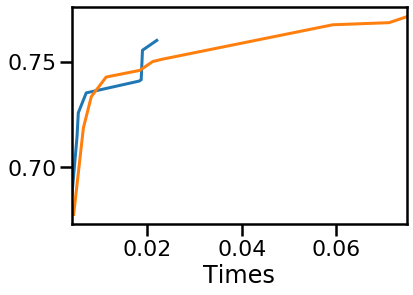

In [49]:
sns.tsplot()

TB.plot()
TB_full.plot()

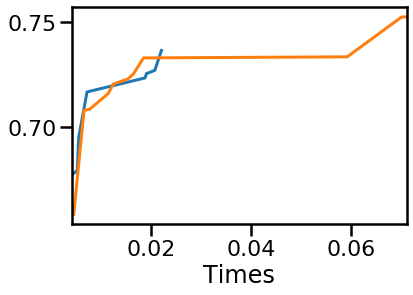

In [50]:
TM.plot()
TM_full.plot()

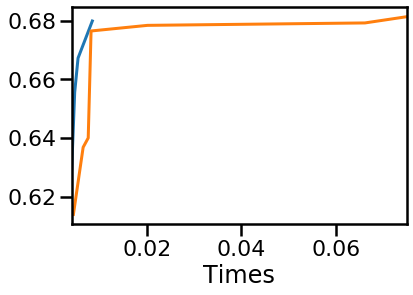

In [51]:
BB.plot()
BB_full.plot()

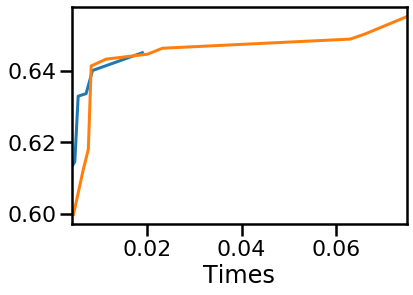

In [52]:
BM.plot()
BM_full.plot()

In [114]:
newSelection('sensor','Tremor','Binary')

Forward
cj
fj
tej
Backward
ftec
ftej
fecj
fte
fej
tecj
tej
ecj


In [139]:
newSelection('sensor','Tremor','Multiclass')

Forward
tj
fj
ftej
Backward
ftec
ftej
fecj
fej
tecj
tej
ecj


In [140]:
newSelection('sensor','Bradykinesia','Binary')

Forward
t
ftj
Backward
ftec
ftej
fte
fej
tecj
tec
tej
ftj
fj
tj


In [141]:
newSelection('sensor','Bradykinesia','Multiclass')

Forward
tj
Backward
ftec
ftej
fte
fej
tecj
fe
tej
ftj
ft
fj
tj


In [176]:
current = 'ftecj'
for g in D.index.values[-2:0:-1]:
    auc_group = AUC[g].mean()-AUC[current].mean()
    auc_sem = stats.sem(AUC[g].values-AUC[current].mean(), nan_policy='omit')
    p = stats.ttest_rel(AUC[g],AUC[current],nan_policy='omit')
    print(p)
    if (p[1]>.05) or (p[0]>0):
        print(g)
        if p[0]>0:
            current = g

Ttest_relResult(statistic=-1.647121778048876, pvalue=0.1277736115690739)
ftec
Ttest_relResult(statistic=1.2659802789311794, pvalue=0.23167481311648624)
ftej
Ttest_relResult(statistic=-1.3010444348987111, pvalue=0.21983590263211272)
fte
Ttest_relResult(statistic=-1.7437876780823123, pvalue=0.10903774412725462)
tecj
Ttest_relResult(statistic=-0.28384236822490605, pvalue=0.7818026128396701)
fecj
Ttest_relResult(statistic=-1.8610483362665906, pvalue=0.0896558072139631)
tec
Ttest_relResult(statistic=-1.7275654675268532, pvalue=0.11199882438027745)
tej
Ttest_relResult(statistic=-0.2057628682778607, pvalue=0.8407347045267207)
fec
Ttest_relResult(statistic=0.013454673776242572, pvalue=0.9895059754875675)
fej
Ttest_relResult(statistic=-2.1535200139592154, pvalue=0.05431335021761517)
fe
Ttest_relResult(statistic=-1.4776846560046983, pvalue=0.1675433092016442)
ecj
Ttest_relResult(statistic=-0.7366562540550772, pvalue=0.47674900375998586)
te
Ttest_relResult(statistic=-0.7104030255140755, pvalue=0.

In [366]:
plt.figure(figsize=(10,15))
sns.heatmap(D.drop(columns=['Times']))

KeyError: "['Times'] not found in axis"

<Figure size 720x1080 with 0 Axes>

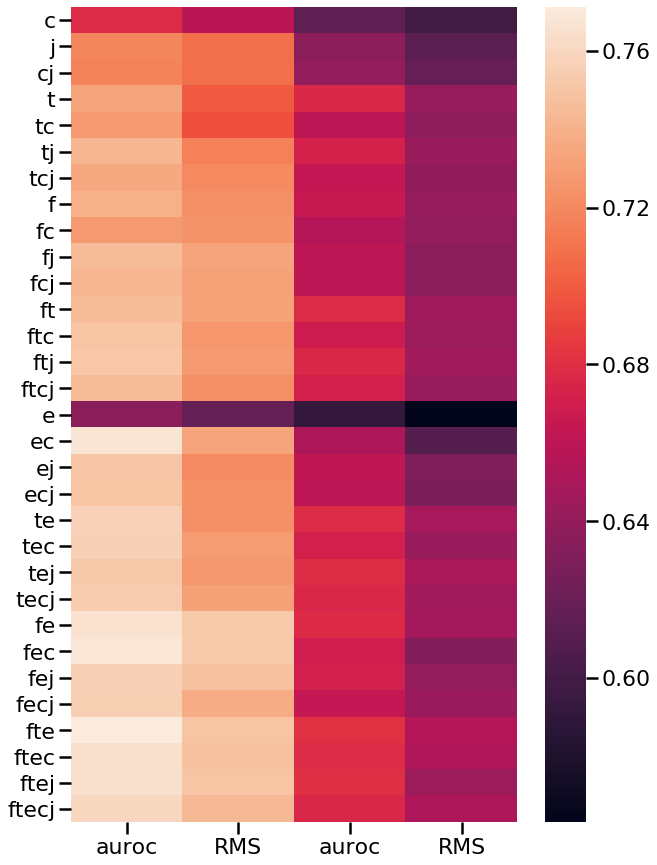

In [40]:
plt.figure(figsize=(10,15))
sns.heatmap(D.drop(columns=['Times']))
plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\HeatMap.svg')

In [ ]:
multi_res_groups

In [3]:
#Open results as pickle file

f = open('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Results\\FeaturesAnalysisResults','rb')
results = pickle.load(f)
f.close()

In [ ]:
def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None,ls='-',lw=3):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=lw,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=lw,linestyle=ls)
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [ ]:
def ForwardSelection(mode,symptom,classifier,CIBound=False,CIZ=1.98,tol=.05):
    
    # Set plot parameters
    plotStyles = [(0, (1, 10)), ':', '-.', '--', '-']
    plotCol = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    lw=5
    plt.figure(figsize=(12,9))
    
    groups = results[mode][symptom][classifier]['res_all']['Combination'].values
    data = results[mode][symptom][classifier]['res_groups']
    
    done = False
    opt_feat = ''
    if classifier == 'Regressor':
        current_auc = sys.maxsize
    else:
        current_auc = 0
    
    AUC = pd.DataFrame()
    if classifier == 'Binary':
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']
    else:
        for g in groups:
            AUC[g] = data[g]['Random Forest']['RMS']

    plotInd = 0
            
    while not done:
        n = len(opt_feat)+1
        n_groups = [g for g in groups if len(g)==n and all([(o in g) for o in opt_feat]) and 'm' not in g]
        if len(n_groups)<1:
            break
        auc_groups = np.array([AUC[g].mean()-np.nanmean(current_auc) for g in n_groups])
        auc_sem = np.array([stats.sem(AUC[g].values-current_auc, nan_policy='omit') for g in n_groups])
        
        if classifier == 'Regressor':
            auc_groups = auc_groups*-1

        if CIBound:
            options = [(auc_groups[i],i) for i in range(len(auc_groups)) if auc_groups[i]-(CIZ*auc_sem[i])>0]
            options = []
            if len(options)>0:
                opt_ind = max(options)[1]
            else:
                opt_ind = np.argmax([auc_groups[i] for i in range(len(auc_groups))])
            gate = auc_groups[opt_ind]-(CIZ*auc_sem[opt_ind])>0
            print(auc_groups,auc_groups-CIZ*auc_sem)
        else:
            opt_ind = np.argmax(auc_groups)
            gate = auc_groups[opt_ind]>0
            print(auc_groups)

        opt_feat = n_groups[opt_ind]
            
        if gate:
            current_auc = AUC[opt_feat].values
            print(opt_feat,np.nanmean(current_auc))
        else:
            done = True

        ax = plot_roc(np.vstack([d for d in data[opt_feat]['Random Forest']['tpr'] if len(d)>0]),
                      data[opt_feat]['Random Forest']['fpr'][0],np.nanmean(AUC[opt_feat].values),
                      plotname=opt_feat,col = plotCol[plotInd], ls = plotStyles[plotInd], lw=lw)
        plotInd+=1
    
    n_groups = ['m'] 
    auc_groups = np.array([AUC[g].mean()-np.nanmean(current_auc) for g in n_groups])
    auc_sem = np.array([stats.sem(AUC[g].values-current_auc, nan_policy='omit') for g in n_groups])

    if classifier == 'Regressor':
        auc_groups = auc_groups*-1

    if CIBound:
        options = [(auc_groups[i],i) for i in range(len(auc_groups)) if auc_groups[i]-(CIZ*auc_sem[i])>0]
        options = []
        if len(options)>0:
            opt_ind = max(options)[1]
        else:
            opt_ind = np.argmax([auc_groups[i] for i in range(len(auc_groups))])
        gate = auc_groups[opt_ind]-(CIZ*auc_sem[opt_ind])>0
        print(auc_groups,auc_groups-CIZ*auc_sem)
    else:
        opt_ind = np.argmax(auc_groups)
        gate = auc_groups[opt_ind]>0
        print(auc_groups)

    opt_feat = n_groups[opt_ind]

    T = PairedT(current_auc,AUC[opt_feat].values)
    print(opt_feat,np.nanmean(current_auc),T)
        
    ax = plot_roc(np.vstack([d for d in data[opt_feat]['Random Forest']['tpr'] if len(d)>0]),
                  data[opt_feat]['Random Forest']['fpr'][0],np.nanmean(AUC[opt_feat].values),
                  plotname=opt_feat,col = plotCol[plotInd], ls = plotStyles[plotInd], lw=lw)
    
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    ax.set_xlabel(ax.get_xlabel(), fontsize=30)
    ax.set_ylabel(ax.get_ylabel(), fontsize=30)
    ax.legend(loc=4,fontsize=22)
    
    plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\FeaturesForward\\' + mode + '-' + symptom + '-' + classifier + '.svg')

In [ ]:
def BackwardSelection(mode,symptom,classifier,CIBound=False,CIZ=1.98,tol=.05):
    
    # Set plot parameters
    plotStyles = ['-', '--', '-.', ':', (0, (1, 10))]
    plotCol = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    lw=5
    plt.figure(figsize=(12,9))
    
    groups = results[mode][symptom][classifier]['res_all']['Combination'].values
    data = results[mode][symptom][classifier]['res_groups']
    
    done = False
    opt_feat = 'ftcj'
    
    AUC = pd.DataFrame()
    if classifier == 'Binary':
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']
    else:
        for g in groups:
            AUC[g] = data[g]['Random Forest']['RMS']

    current_auc = AUC[opt_feat]
      
    plotInd = 0
        
    ax = plot_roc(np.vstack([d for d in data[opt_feat]['Random Forest']['tpr'] if len(d)>0]),
             data[opt_feat]['Random Forest']['fpr'][0],np.nanmean(AUC[opt_feat].values),
             plotname=opt_feat,col = plotCol[plotInd], ls = plotStyles[plotInd], lw=lw)
        
    while not done:
        n = len(opt_feat)-1
        n_groups = [g for g in groups if len(g)==n and all([(g_char in opt_feat) for g_char in g])]
        print(n_groups)
        if len(n_groups)<1:
            break
        auc_groups = np.array([AUC[g].mean()-np.nanmean(current_auc) for g in n_groups])
        auc_sem = np.array([stats.sem(AUC[g].values-current_auc, nan_policy='omit') for g in n_groups])

        if CIBound:
#             options = [(auc_groups[i],i) for i in range(len(auc_groups)) if auc_groups[i]+(CIZ*auc_sem[i])>0]
            options = []
            if len(options)>0:
                opt_ind = max(options)[1]
            else:
                opt_ind = np.argmax(auc_groups)
            gate = auc_groups[opt_ind]+(CIZ*auc_sem[opt_ind])>0
            print(auc_groups,auc_groups+CIZ*auc_sem)
        else:
            opt_ind = np.argmax(auc_groups)
            gate = auc_groups[opt_ind]>0
            print(auc_groups)

        opt_feat = n_groups[opt_ind]
            
        if gate:
            if auc_groups[opt_ind]>0:
                current_auc = AUC[opt_feat].values
            print(opt_feat,np.nanmean(current_auc))
        else:
            done = True
        
        plotInd+=1
        
        plot_roc(np.vstack([d for d in data[opt_feat]['Random Forest']['tpr'] if len(d)>0]),
                 data[opt_feat]['Random Forest']['fpr'][0],np.nanmean(AUC[opt_feat].values),
                 plotname=opt_feat,col = plotCol[plotInd], ls = plotStyles[plotInd], lw=lw)
    
    n_groups = ['m'] 
    auc_groups = np.array([AUC[g].mean()-np.nanmean(current_auc) for g in n_groups])
    auc_sem = np.array([stats.sem(AUC[g].values-current_auc, nan_policy='omit') for g in n_groups])

    if CIBound:
#             options = [(auc_groups[i],i) for i in range(len(auc_groups)) if auc_groups[i]+(CIZ*auc_sem[i])>0]
        options = []
        if len(options)>0:
            opt_ind = max(options)[1]
        else:
            opt_ind = np.argmax(auc_groups)
        gate = auc_groups[opt_ind]+(CIZ*auc_sem[opt_ind])>0
        print(auc_groups,auc_groups+CIZ*auc_sem)
    else:
        opt_ind = np.argmax(auc_groups)
        gate = auc_groups[opt_ind]>0
        print(auc_groups)

    opt_feat = n_groups[opt_ind]

    T = PairedT(current_auc,AUC[opt_feat].values)
    print(opt_feat,np.nanmean(current_auc),T)
        
    plotInd+=1

    plot_roc(np.vstack([d for d in data[opt_feat]['Random Forest']['tpr'] if len(d)>0]),
             data[opt_feat]['Random Forest']['fpr'][0],np.nanmean(AUC[opt_feat].values),
             plotname=opt_feat,col = plotCol[plotInd], ls = plotStyles[plotInd], lw=lw)
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    ax.set_xlabel(ax.get_xlabel(), fontsize=30)
    ax.set_ylabel(ax.get_ylabel(), fontsize=30)
    ax.legend(loc=4,fontsize=22)
    
    plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\FeaturesBackward\\' + mode + '-' + symptom + '-' + classifier + '.svg')

In [ ]:
def PairedT(A,B):
    A = np.array(A); B = np.array(B)
    inds = np.isnan(A) | np.isnan(B)
    inds = np.array(~inds)
    return ttest_rel(A[inds],B[inds])

In [ ]:
ForwardSelection('watch','Tremor','Binary',True,1.98)
PairedT(results['watch']['Tremor']['Binary']['res_groups']['t']['Random Forest']['auroc'],
        results['watch']['Tremor']['Binary']['res_groups']['m']['Random Forest']['auroc'])

In [ ]:
ForwardSelection('watch','Tremor','Multiclass',True,1.98)
PairedT(results['watch']['Tremor']['Multiclass']['res_groups']['t']['Random Forest']['RMS'],
        results['watch']['Tremor']['Multiclass']['res_groups']['m']['Random Forest']['RMS'])

In [ ]:
BackwardSelection('watch','Tremor','Binary',True,1.98)
PairedT(results['watch']['Tremor']['Binary']['res_groups']['t']['Random Forest']['auroc'],
        results['watch']['Tremor']['Binary']['res_groups']['m']['Random Forest']['auroc'])

In [ ]:
BackwardSelection('watch','Tremor','Multiclass',True,1.98)
PairedT(results['watch']['Tremor']['Multiclass']['res_groups']['t']['Random Forest']['RMS'],
        results['watch']['Tremor']['Multiclass']['res_groups']['m']['Random Forest']['RMS'])

In [ ]:
ForwardSelection('watch','Bradykinesia','Binary',True,1.98)
PairedT(results['watch']['Bradykinesia']['Binary']['res_groups']['t']['Random Forest']['auroc'],
        results['watch']['Bradykinesia']['Binary']['res_groups']['m']['Random Forest']['auroc'])

In [ ]:
ForwardSelection('watch','Bradykinesia','Multiclass',True,1.98)
PairedT(results['watch']['Bradykinesia']['Multiclass']['res_groups']['t']['Random Forest']['RMS'],
        results['watch']['Bradykinesia']['Multiclass']['res_groups']['m']['Random Forest']['RMS'])

In [ ]:
BackwardSelection('watch','Bradykinesia','Binary',True,1.98)
PairedT(results['watch']['Bradykinesia']['Binary']['res_groups']['t']['Random Forest']['auroc'],
        results['watch']['Bradykinesia']['Binary']['res_groups']['m']['Random Forest']['auroc'])

In [ ]:
BackwardSelection('watch','Bradykinesia','Multiclass',True,1.98)
PairedT(results['watch']['Bradykinesia']['Multiclass']['res_groups']['t']['Random Forest']['RMS'],
        results['watch']['Bradykinesia']['Multiclass']['res_groups']['m']['Random Forest']['RMS'])

In [ ]:
ForwardSelection('sensor','Tremor','Binary',True,1.98)
PairedT(results['sensor']['Tremor']['Binary']['res_groups']['t']['Random Forest']['auroc'],
        results['sensor']['Tremor']['Binary']['res_groups']['m']['Random Forest']['auroc'])

In [ ]:
ForwardSelection('sensor','Tremor','Multiclass',True,1.98)
PairedT(results['sensor']['Tremor']['Multiclass']['res_groups']['t']['Random Forest']['RMS'],
        results['sensor']['Tremor']['Multiclass']['res_groups']['m']['Random Forest']['RMS'])

In [ ]:
BackwardSelection('sensor','Tremor','Binary',True,1.98)
PairedT(results['sensor']['Tremor']['Binary']['res_groups']['t']['Random Forest']['auroc'],
        results['sensor']['Tremor']['Binary']['res_groups']['m']['Random Forest']['auroc'])

In [ ]:
BackwardSelection('sensor','Tremor','Multiclass',True,1.98)
PairedT(results['sensor']['Tremor']['Multiclass']['res_groups']['t']['Random Forest']['RMS'],
        results['sensor']['Tremor']['Multiclass']['res_groups']['m']['Random Forest']['RMS'])

In [ ]:
ForwardSelection('sensor','Bradykinesia','Binary',True,1.98)
PairedT(results['sensor']['Bradykinesia']['Binary']['res_groups']['t']['Random Forest']['auroc'],
        results['sensor']['Bradykinesia']['Binary']['res_groups']['m']['Random Forest']['auroc'])

In [ ]:
ForwardSelection('sensor','Bradykinesia','Multiclass',True,1.98)
PairedT(results['sensor']['Bradykinesia']['Multiclass']['res_groups']['t']['Random Forest']['RMS'],
        results['sensor']['Bradykinesia']['Multiclass']['res_groups']['m']['Random Forest']['RMS'])

In [ ]:
BackwardSelection('sensor','Bradykinesia','Binary',True,1.98)
PairedT(results['sensor']['Bradykinesia']['Binary']['res_groups']['t']['Random Forest']['auroc'],
        results['sensor']['Bradykinesia']['Binary']['res_groups']['m']['Random Forest']['auroc'])

In [ ]:
BackwardSelection('sensor','Bradykinesia','Multiclass',True,1.98)
PairedT(results['sensor']['Bradykinesia']['Multiclass']['res_groups']['t']['Random Forest']['RMS'],
        results['sensor']['Bradykinesia']['Multiclass']['res_groups']['m']['Random Forest']['RMS'])

## Full Frequency Results

[0.64957234 0.68862888 0.68140368 0.65012632] [0.57808268 0.55947895 0.58922458 0.58974448]
t 0.6886288807338461
[0.01209253 0.01790419 0.03367217] [-0.01774226 -0.00246601 -0.00558699]
[-0.06250767] [-0.16597075]


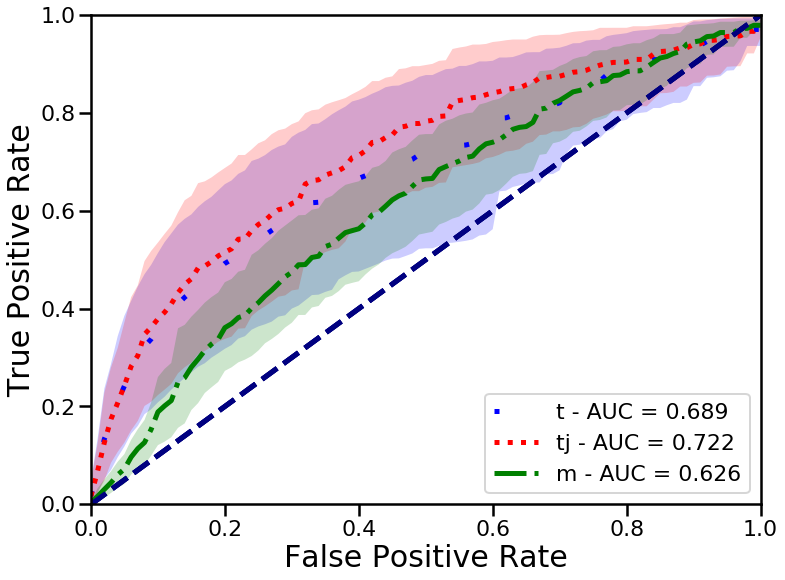

In [36]:
ForwardSelection('watch','Tremor','Binary',True,1.98)

[0.62774494 0.67552768 0.65227923 0.61260449] [0.57243183 0.56948889 0.57655004 0.56720479]
t 0.6755276837155417
[0.00985439 0.0020972  0.01109468] [-0.00061978 -0.00465805  0.00351634]
tj 0.6866223672398841
[-0.01307603  0.00392944] [-0.03477393 -0.00465708]
[-0.04973986] [-0.14626838]


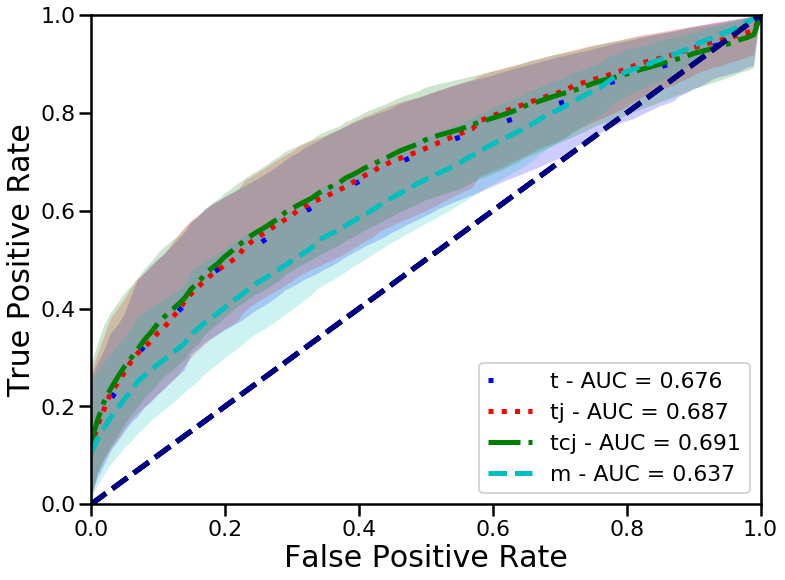

In [37]:
ForwardSelection('watch','Tremor','Multiclass',True,1.98)

['ftc', 'ftj', 'fcj', 'tcj']
[-0.01617783 -0.00219746  0.01431077  0.00358308] [-0.00533403  0.00762054  0.06161755  0.01340444]
fcj 0.739132677951225
['fc', 'fj', 'cj']
[-0.06383802 -0.02097185 -0.00905571] [-0.02445624  0.00879256  0.00407915]
cj 0.739132677951225
['c', 'j']
[-0.057729   -0.08900636] [-0.03025251 -0.03977401]
[-0.11301147] [-0.07978856]


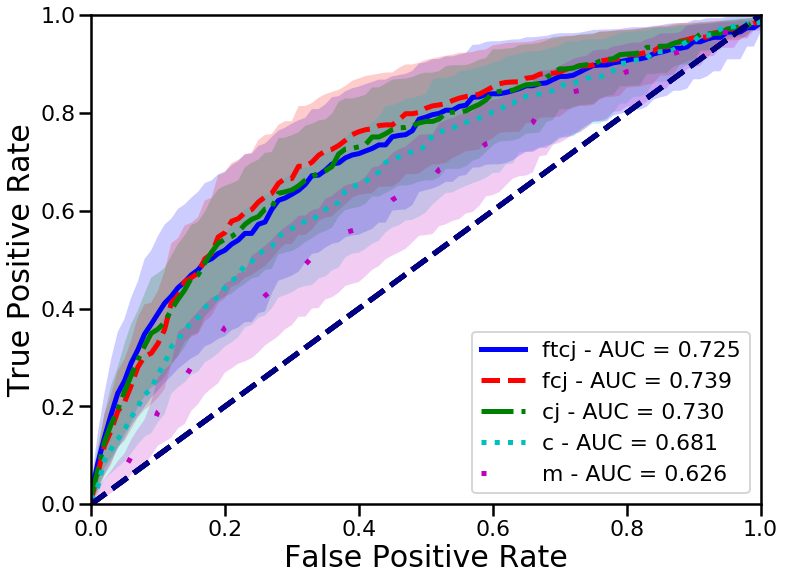

In [38]:
BackwardSelection('watch','Tremor','Binary',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftcj', 'ftcm', 'ftjm', 'fcjm', 'tcjm']
[-0.00417971 -0.00129927 -0.00134066  0.00269025 -0.00096364] [0.00387622 0.00568948 0.00455996 0.02430681 0.00533666]
fcjm 0.7342896558970955
['fcj', 'fcm', 'fjm', 'cjm']
[-0.0097294  -0.02420394 -0.00665151 -0.01083965] [ 0.0006025  -0.00477616  0.01360045 -0.00124185]
fjm 0.7276381432409388
['fj', 'fm', 'jm']
[-0.03071385 -0.01017926 -0.00628005] [-0.01876695  0.00096063  0.00214503]
jm 0.7213580898909782
['j', 'm']
[-0.07321115 -0.01543889] [-0.03472176 -0.00570002]


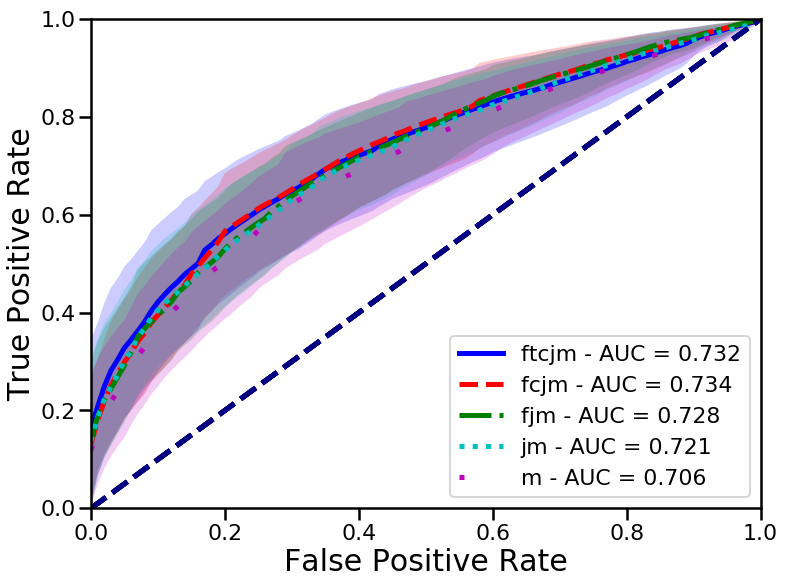

In [129]:
BackwardSelection('watch','Tremor','Multiclass',True,1.98)

[0.59084047 0.60495845 0.61465267 0.57637163 0.59504909] [0.53903998 0.54744566 0.5522752  0.51923741 0.53291753]
c 0.6146526709416694


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[-0.00688353  0.00202408 -0.00488358 -0.00147213] [-0.02869863 -0.02855829 -0.02502203 -0.0239676 ]


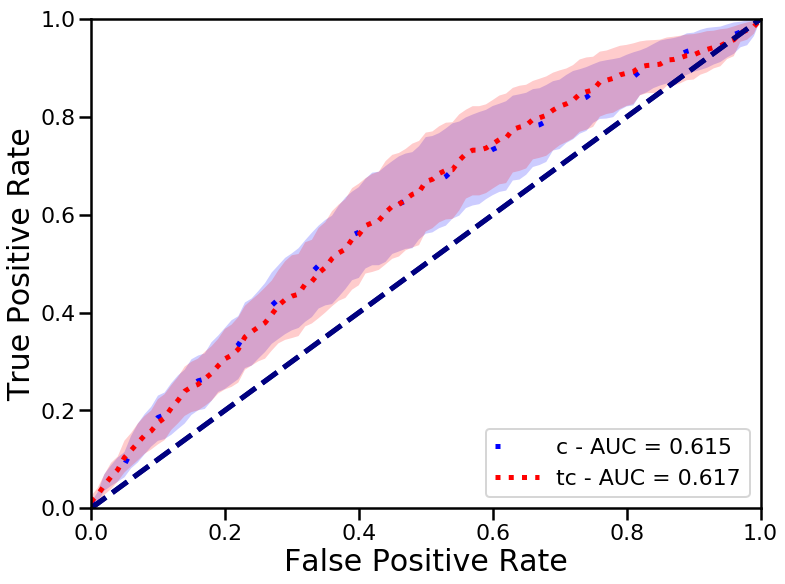

In [130]:
ForwardSelection('watch','Bradykinesia','Binary',True,1.98)

[0.57954633 0.5844103  0.59050081 0.56414244 0.57515929] [0.54069583 0.53364575 0.54211008 0.5217076  0.52450883]
c 0.5905008133277089


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[-0.00132369 -0.01141793 -0.01186572 -0.00622109] [-0.01816968 -0.05142558 -0.02721478 -0.03684049]


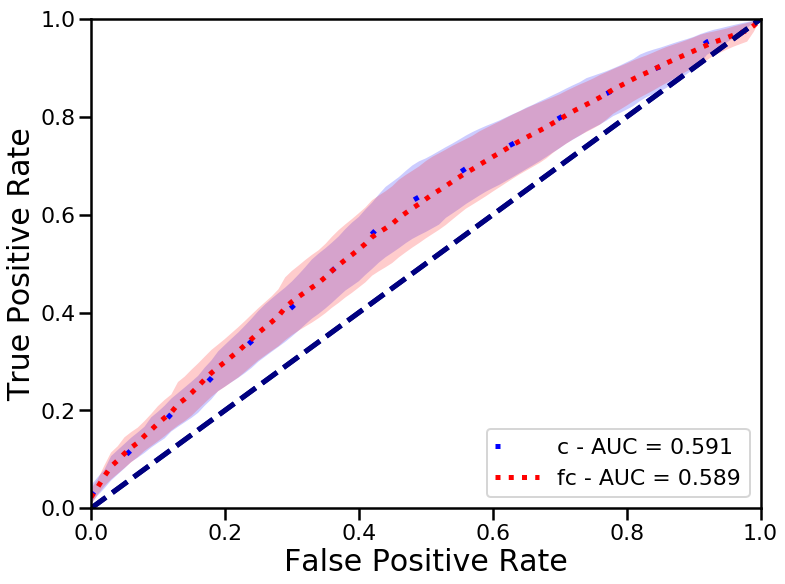

In [131]:
ForwardSelection('watch','Bradykinesia','Multiclass',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftcj', 'ftcm', 'ftjm', 'fcjm', 'tcjm']
[ 0.00427031 -0.01404325 -0.01450113 -0.01079502 -0.00541588] [ 0.01313263 -0.00204844  0.00418041  0.01164706  0.00483634]
ftcj 0.6262974145112475
['ftc', 'ftj', 'fcj', 'tcj']
[-0.01886573 -0.00829915 -0.01519274 -0.01193639] [-0.0070124   0.00131539  0.01058545 -0.00332865]
ftj 0.6179982627999994
['ft', 'fj', 'tj']
[-0.00586184 -0.01859467 -0.00449177] [0.00729999 0.0173976  0.00757715]
tj 0.6135064930610107
['t', 'j']
[-0.00854805 -0.03713486] [0.00922798 0.00029509]
t 0.6049584475153459
[]


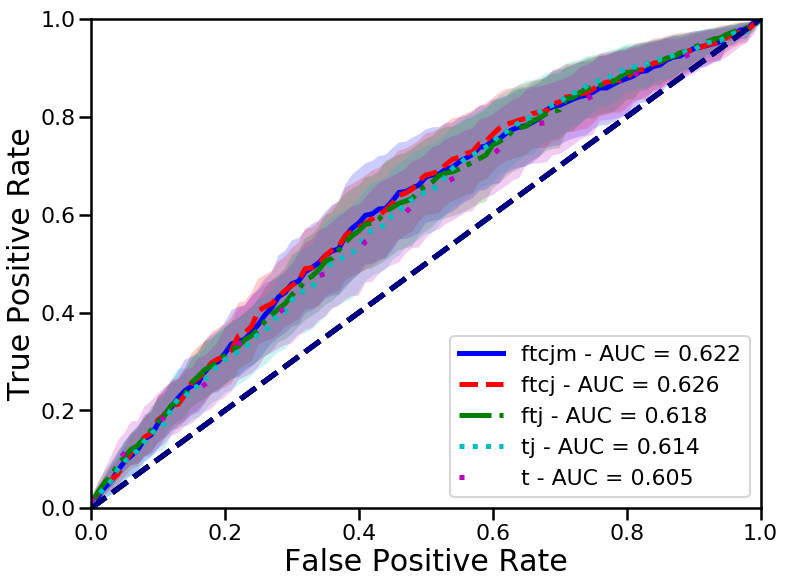

In [132]:
BackwardSelection('watch','Bradykinesia','Binary',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftcj', 'ftcm', 'ftjm', 'fcjm', 'tcjm']
[0.00671474 0.0015732  0.00042637 0.01255815 0.00811523] [0.01705156 0.0110557  0.01665176 0.04029799 0.02095688]
fcjm 0.595730251815616
['fcj', 'fcm', 'fjm', 'cjm']
[-0.01199796 -0.0133667  -0.00113586 -0.00253086] [-1.53697098e-03  1.66226002e-05  8.81614278e-03  1.02964596e-02]
fjm 0.5945943884833096
['fj', 'fm', 'jm']
[-0.00787459 -0.00496623  0.00440814] [0.00431976 0.00636793 0.01434027]
jm 0.5990025316428287
['j', 'm']
[-0.03486009 -0.02384324] [-0.0034896 -0.0109785]


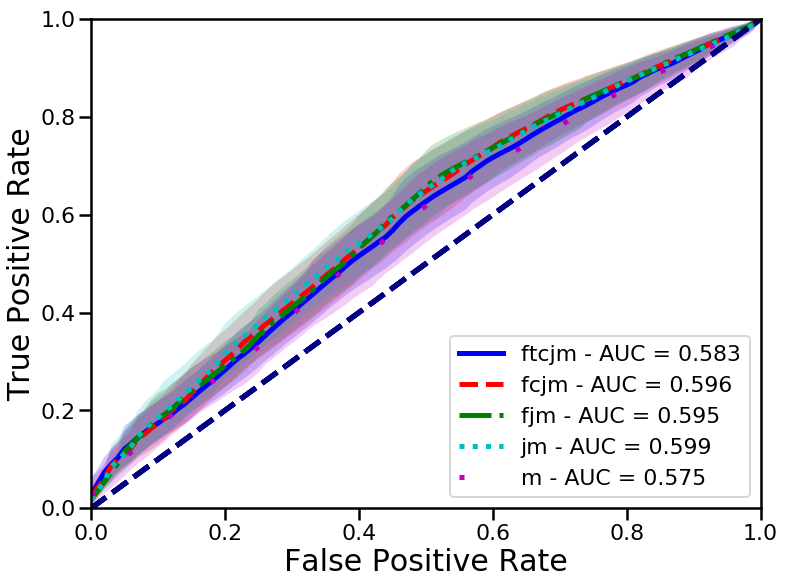

In [133]:
BackwardSelection('watch','Bradykinesia','Multiclass',True,1.98)

[0.67253949 0.76133949 0.67568157 0.7036886  0.76014521] [0.61983834 0.66939147 0.58467967 0.6241786  0.68658518]
t 0.7613394901022844


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[-0.00299547 -0.00531533 -0.00121891  0.00426849] [-0.01183354 -0.01557043 -0.01642706 -0.0036183 ]


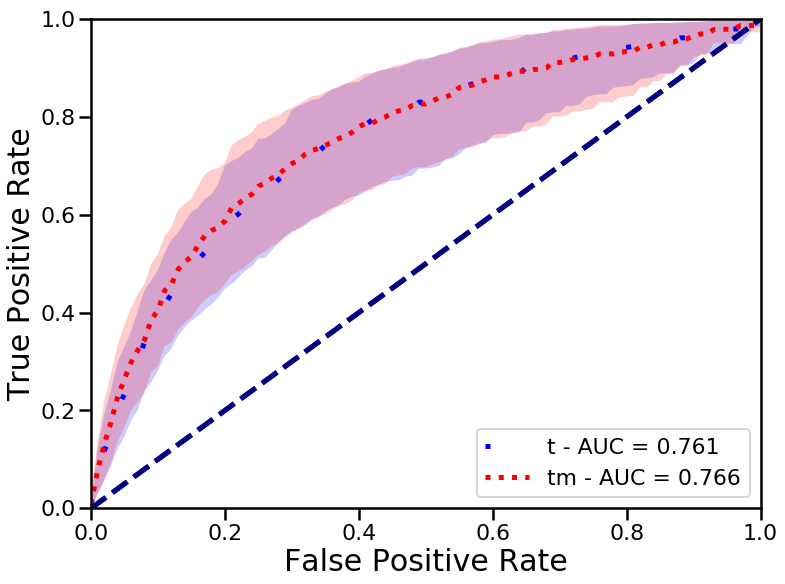

In [134]:
ForwardSelection('sensor','Tremor','Binary',True,1.98)

[0.64335573 0.72293033 0.65908872 0.69052533 0.73332437] [0.59070331 0.63693969 0.57741114 0.61310487 0.66016183]
m 0.7333243680553516


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[0.00089595 0.00390222 0.00293796 0.00485486] [-0.00998667 -0.01778193 -0.01666427 -0.01464886]


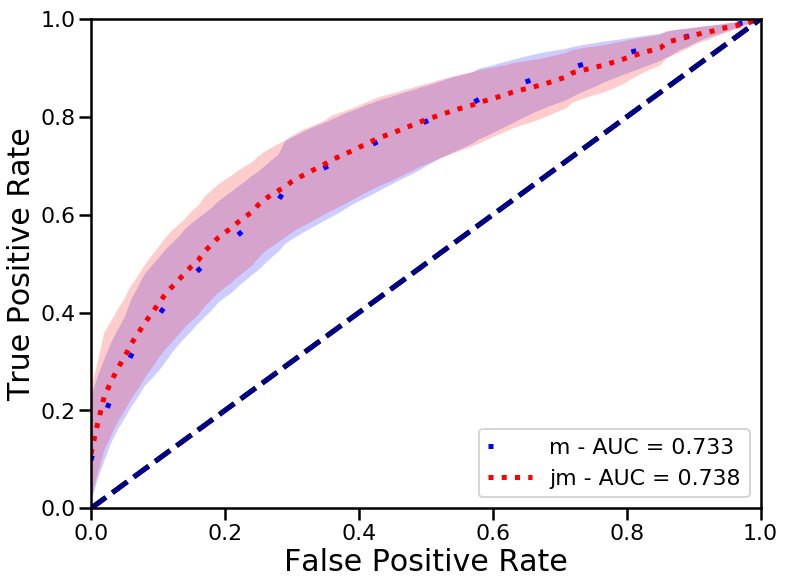

In [135]:
ForwardSelection('sensor','Tremor','Multiclass',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftcj', 'ftcm', 'ftjm', 'fcjm', 'tcjm']
[ 0.0024475   0.00719755  0.00851759 -0.00348472  0.00488457] [0.00881345 0.02000988 0.01373656 0.01325546 0.0093896 ]
ftjm 0.7669448999445733
['ftj', 'ftm', 'fjm', 'tjm']
[-0.00677456  0.00058691 -0.00273991  0.00026941] [-0.00197375  0.00792976  0.02577336  0.00899297]
ftm 0.7675318100151322
['ft', 'fm', 'tm']
[-0.00918779  0.00188593 -0.00192383] [0.00107834 0.02892823 0.00774886]
fm 0.7694177443923736
['f', 'm']
[-0.09687826 -0.00927253] [-0.06299048  0.00113149]
m 0.7601452104867127
[]


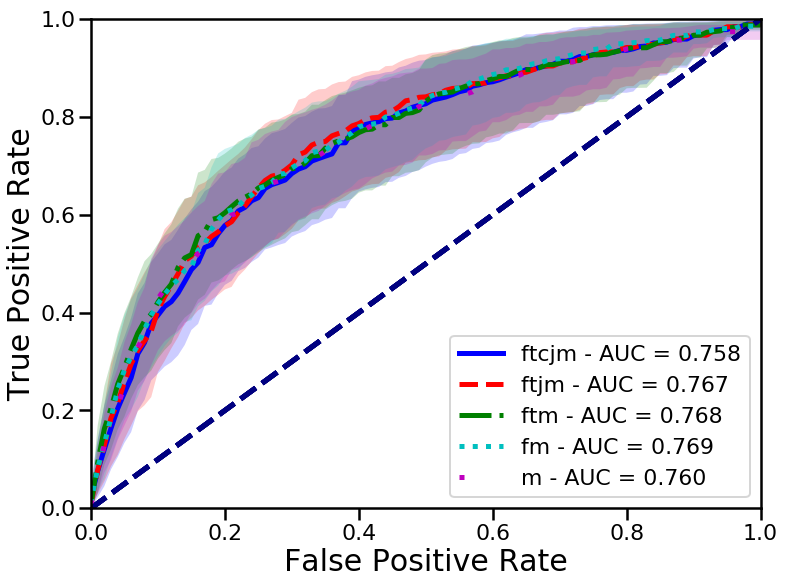

In [136]:
BackwardSelection('sensor','Tremor','Binary',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftcj', 'ftcm', 'ftjm', 'fcjm', 'tcjm']
[-6.78503568e-03  1.45345751e-03  7.05900912e-05  5.73244370e-03
  1.29073106e-03] [-0.00165449  0.01226609  0.00477592  0.02463347  0.01383763]
fcjm 0.7405349699398923
['fcj', 'fcm', 'fjm', 'cjm']
[-0.04917557  0.00107621  0.0048627  -0.00197651] [0.01616694 0.01719711 0.01615724 0.01054459]
fjm 0.745397672128
['fj', 'fm', 'jm']
[-0.03688661 -0.01117736 -0.00721844] [-0.01413203  0.00221718 -0.00085951]


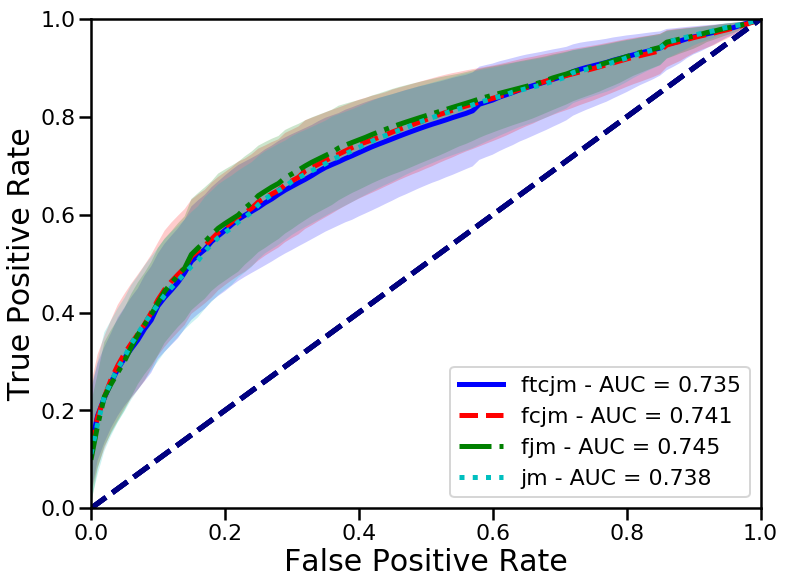

In [137]:
BackwardSelection('sensor','Tremor','Multiclass',True,1.98)

[0.64898344 0.67680078 0.62607211 0.62942212 0.66364946] [0.60434054 0.61307332 0.55217281 0.57227221 0.61055325]
t 0.6768007751327507


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[ 0.00763979 -0.00797629  0.00429873  0.01181813] [-0.0009043  -0.02564053 -0.00375295 -0.00043224]


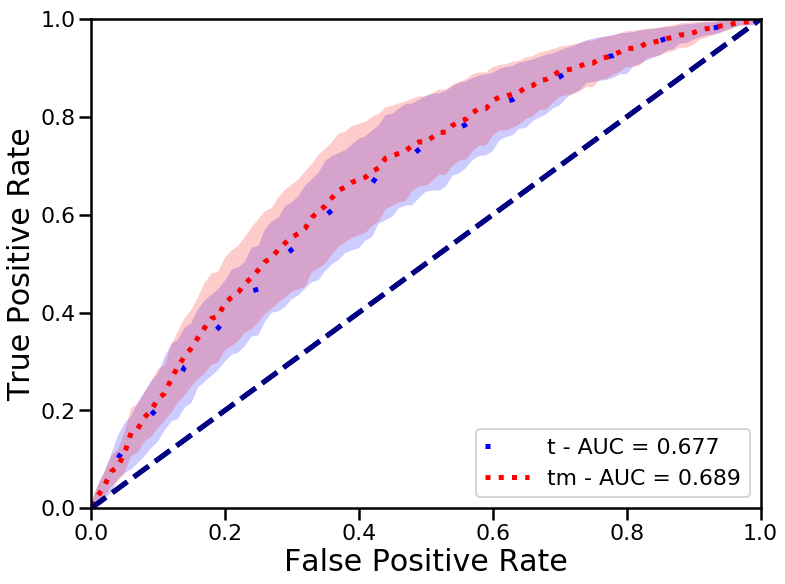

In [138]:
ForwardSelection('sensor','Bradykinesia','Binary',True,1.98)

[0.62190772 0.65189014 0.60267287 0.61639071 0.63353874] [0.57374297 0.59591476 0.54144768 0.56403912 0.57593283]
t 0.6518901436976099


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[ 0.00783481 -0.00361147  0.00073657  0.00279089] [-0.00155568 -0.01340804 -0.01113486 -0.00241187]


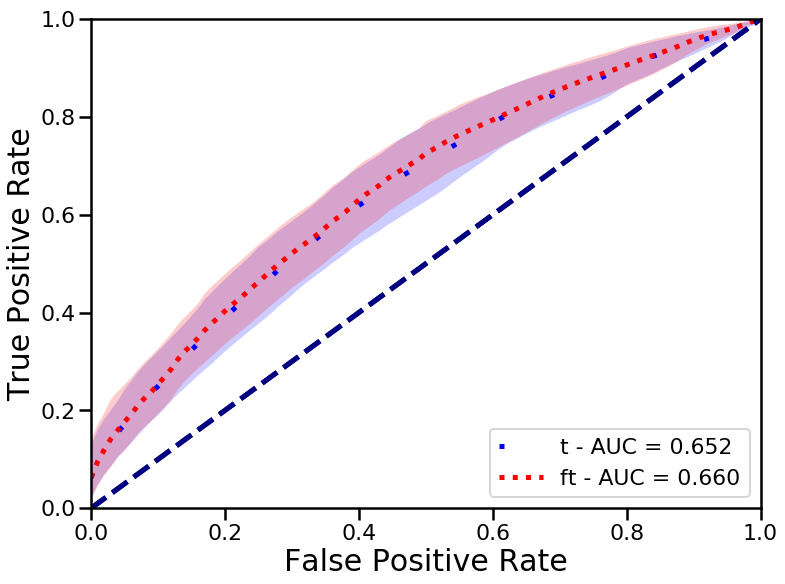

In [139]:
ForwardSelection('sensor','Bradykinesia','Multiclass',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftcj', 'ftcm', 'ftjm', 'fcjm', 'tcjm']
[-0.0052403  -0.00263404  0.0057088  -0.03067915 -0.00413513] [ 0.003207    0.00816523  0.02061903 -0.01175286  0.0067253 ]
ftjm 0.6883338848025324
['ftj', 'ftm', 'fjm', 'tjm']
[-0.01225871 -0.00568744 -0.01408834 -0.00549541] [-0.00088447  0.00697675  0.01680169  0.00099254]
tjm 0.6828384783905582
['tj', 'tm', 'jm']
[-0.00173897  0.00578043 -0.01457192] [0.0072251  0.0153133  0.01570257]
tm 0.6886189070460726
['t', 'm']
[-0.01181813 -0.02496945] [0.00043224 0.00617661]
t 0.6768007751327507
[]


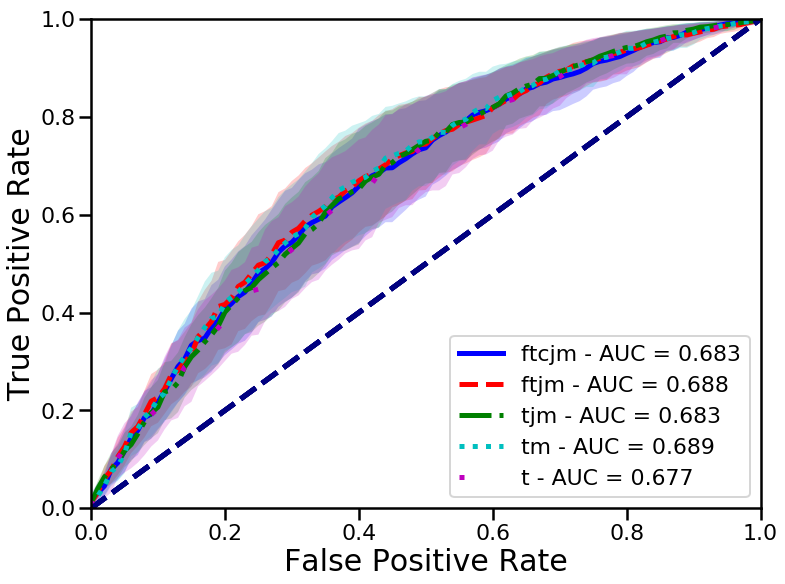

In [140]:
BackwardSelection('sensor','Bradykinesia','Binary',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftcj', 'ftcm', 'ftjm', 'fcjm', 'tcjm']
[-0.00604175 -0.00869863 -0.004592   -0.01888522 -0.01111681] [ 0.0056578  -0.00011531  0.00651621 -0.00418792 -0.00309026]
ftjm 0.655196858220057
['ftj', 'ftm', 'fjm', 'tjm']
[ 0.0060291   0.00467503 -0.00958272  0.00144555] [0.01802    0.01696775 0.0130765  0.01567383]
ftj 0.6612259610621474
['ft', 'fj', 'tj']
[-0.00150101 -0.03008566 -0.00859925] [0.00819521 0.00253893 0.0027926 ]
ft 0.659724951197068
['f', 't']
[-0.03781723 -0.00783481] [-0.00686483  0.00155568]
t 0.6518901436976099
[]


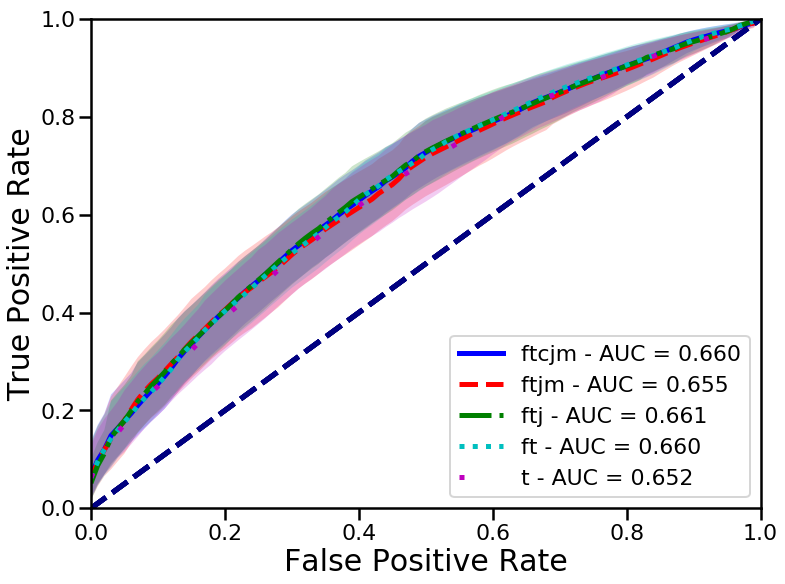

In [141]:
BackwardSelection('sensor','Bradykinesia','Multiclass',True,1.98)

In [53]:
from sklearn.feature_selection import RFE

In [ ]:
RFE

In [87]:
m = np.mean([0.6352951233281823, 0.7422959437907404, 0.6841052040488516, 0.6481000388384809, 0.7196329789918051])
s = np.std([0.6352951233281823, 0.7422959437907404, 0.6841052040488516, 0.6481000388384809, 0.7196329789918051])

In [142]:
[-9.223372036854776e+18, -9.223372036854776e+18, -9.223372036854776e+18, -9.223372036854776e+18, -9.223372036854776e+18]*-1

[]

In [115]:
mode = 'watch'; symptom = 'Tremor'; classifier = 'Binary'; CIBound = True; CIZ = 1.98

groups = results[mode][symptom][classifier]['res_all']['Combination'].values
data = results[mode][symptom][classifier]['res_groups']

done = False
opt_feat = ''
current_auc = 0

if classifier == 'Binary':

    AUC = pd.DataFrame()
    for i in range(len(data)):
        AUC[groups[i]] = data[i]['Random Forest']['auroc']


    while not done:
        n = len(opt_feat)+1
        n_groups = [g for g in groups if (len(g)==n) & all([(o in g) for o in opt_feat])]
        if len(n_groups)<1:
            break
        auc_groups = [AUC[g].mean()-np.nanmean(current_auc) for g in n_groups]
        auc_sem = [stats.sem(aucdf[g].values-current_auc, nan_policy='omit') for g in n_groups]
        print(auc_groups,[g-CIZ*s for g,s in zip(auc_groups, auc_sem)])
        max_ind = np.argmax(auc_groups)
        if CIBound:
            if (auc_groups[max_ind]-(CIZ*auc_sem[max_ind]))>0:
                opt_feat = n_groups[max_ind]
                current_auc = aucdf[opt_feat].values
                print(opt_feat,current_auc)
            else:
                done = True
        else:
            if auc_groups[max_ind]>np.mean(current_auc):
                opt_feat = n_groups[max_ind]
                current_auc = AUC[opt_feat]
                print(opt_feat,current_auc)
            else:
                done = True

[0.6352951233281823, 0.7422959437907404, 0.6841052040488516, 0.6481000388384809, 0.7196329789918051] [0.5584174275461221, 0.6241088839085511, 0.601897422547087, 0.5863983287020665, 0.6271129660188752]
t [0.70561294 0.81037706 0.86186017 0.73196066 0.35612374 0.72138692
 0.7516752  0.99869281 0.94657467 0.82804711        nan 0.24381238
 0.86427346 0.82945014]
[0.00016780670521299168, 0.002212182690734754, 0.006437808633695585, -0.0009021098001887884] [-0.008308870837258852, -0.0026934758857538174, -0.0051464284074526825, -0.009070958307743392]


In [106]:
auc_sem

[nan, nan, nan, nan, nan]

In [10]:
def barplotFeatures(mode,symptom,classifier):
    if classifier == 'Binary':
        groups = results[mode][symptom][classifier]['res_all']['Combination'].values
        aucdf = pd.DataFrame()
        data = results[mode][symptom][classifier]['res_groups']
        for i in range(len(data)):
            aucdf[groups[i]] = data[i]['Random Forest']['auroc']
        sns.barplot(data=aucdf)
        plt.ylabel('AUROC')
        plt.ylim([0,1])
    else:
        groups = results[mode][symptom][classifier]['res_groups']['Combination']
        RMS = results[mode][symptom][classifier]['res_groups']['RMS']
        sns.barplot(groups,RMS,ci='sd')
        plt.ylabel('RMS')
        m = results[mode][symptom][classifier]['res_all']['RMS'].max()
        m = math.ceil((m+.01)*20)/20
        plt.ylim([0,m])
        
    ax = plt.xticks(rotation=90)
    plt.xlabel('Feature Sets')
    plt.title('%s Model Performance v. %s Features: %s'%(classifier,mode,symptom))
    print('f: frequency')
    print('t: time')
    print('c: correlation')
    print('j: jerk')
    print('m: mag')
    
    plt.savefig('Results/Features_%s_%s_%s.png'%(mode,symptom,classifier),format='png',dpi=1000)

In [11]:
def stats_tests(mode,symptom,classifier):
    #dataframe for reorganizing data
    df = pd.DataFrame()
    comblist = list(results[mode][symptom][classifier]['res_all']['Combination'])
    if classifier == 'Binary':
        for i in range(len(comblist)):
            comb = comblist[i]
            df[comb] = pd.Series(results[mode][symptom][classifier]['res_groups'][i]['Random Forest']['auroc'])
        df = df[~df['f'].isnull()].reset_index(drop=True)
    else:
        for comb in comblist:
            df[comb] = results[mode][symptom][classifier]['res_groups'][results[mode][symptom][classifier]['res_groups']['Combination']==comb]['RMS']
        df = df.reset_index(drop=True)

    #rmANOVA
    print()
    print('Repeated Measures ANOVA')
    print('All feature subsets')
    print('pvalue: ' + str(rmANOVA(df,df.columns.values)))
    print('f,t,j,c,m,ftcjm')
    print('pvalue: ' + str(rmANOVA(df,['f','t','j','c','m','ftcjm'])))
    print()
    
    #t tests
    for comb in ['f','t','c','j','m']:
        p = stats.ttest_rel(df['ftcjm'],df[comb])
        print('ftcjm, %s'%comb)
        print(p)

In [12]:
def rmANOVA(df,columns):
    grand_mean = np.mean(df[columns].mean())
    sub_means = np.mean(df[columns],axis=1)
    col_means = np.mean(df[columns],axis=0)
    n = len(df)
    k = len(columns)
    dftotal = n*k - 1
    dfbw = k - 1
    dfsbj = n - 1
    dfw = dftotal - dfbw
    dferror = dfw - dfsbj
    SSbetween = sum(n*[(m-grand_mean)**2 for m in col_means])
    SSwithin = np.nansum(np.nansum([(df[col] - col_means[i])**2 for i,col in enumerate(df[columns])]))
    SSsubject = sum(k*[(m - grand_mean)**2 for m in sub_means])
    SSerror = SSwithin - SSsubject
    SStotal = SSbetween + SSwithin
    msbetween = SSbetween/dfbw
    mserror = SSerror/dferror
    F = msbetween/mserror
    return stats.f.sf(F,dfbw,dferror)

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 1.2407294855751674e-15
f,t,j,c,m,ftcjm
pvalue: 1.838185647828629e-05

ftcjm, f
Ttest_relResult(statistic=4.013325133360871, pvalue=0.0017199744127328195)
ftcjm, t
Ttest_relResult(statistic=1.145317907406181, pvalue=0.27440615312625705)
ftcjm, c
Ttest_relResult(statistic=2.676990119814746, pvalue=0.02014873731864096)
ftcjm, j
Ttest_relResult(statistic=2.8353209569720144, pvalue=0.015026630531448171)
ftcjm, m
Ttest_relResult(statistic=1.5633100588561193, pvalue=0.14395488627636344)


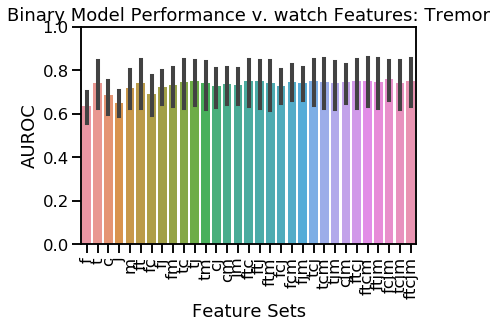

In [14]:
barplotFeatures('watch','Tremor','Binary')
stats_tests('watch','Tremor','Binary')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 8.80291136016951e-69
f,t,j,c,m,ftcjm
pvalue: 8.555604610338152e-11

ftcjm, f
Ttest_relResult(statistic=-6.497546731549849, pvalue=2.011257077481974e-05)
ftcjm, t
Ttest_relResult(statistic=-9.137665359108434, pvalue=5.069081163280519e-07)
ftcjm, c
Ttest_relResult(statistic=1.4452832072014001, pvalue=0.1720505627928243)
ftcjm, j
Ttest_relResult(statistic=-4.235692478549739, pvalue=0.000972729585186152)
ftcjm, m
Ttest_relResult(statistic=-11.322280814619132, pvalue=4.183404420131731e-08)


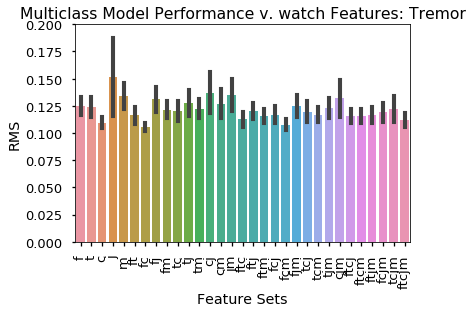

In [98]:
barplotFeatures('watch','Tremor','Multiclass')
stats_tests('watch','Tremor','Multiclass')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 3.2011690391667044e-37
f,t,j,c,m,ftcjm
pvalue: 2.956897821741187e-07

ftcjm, f
Ttest_relResult(statistic=-7.4468636820002505, pvalue=4.855684711357836e-06)
ftcjm, t
Ttest_relResult(statistic=-1.123970306635543, pvalue=0.28135253683103006)
ftcjm, c
Ttest_relResult(statistic=-7.155904374450818, pvalue=7.413102626725193e-06)
ftcjm, j
Ttest_relResult(statistic=-3.5763197236104003, pvalue=0.0033816465118064196)
ftcjm, m
Ttest_relResult(statistic=-8.411565292257393, pvalue=1.2857220922194676e-06)


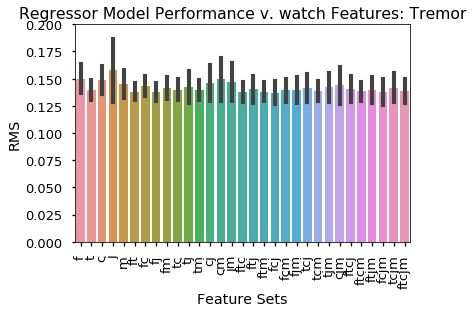

In [99]:
barplotFeatures('watch','Tremor','Regressor')
stats_tests('watch','Tremor','Regressor')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 0.02236252961477201
f,t,j,c,m,ftcjm
pvalue: 0.014054486068820295

ftcjm, f
Ttest_relResult(statistic=2.071765291305611, pvalue=0.05874189913100713)
ftcjm, t
Ttest_relResult(statistic=0.7806440727035838, pvalue=0.4489938411327704)
ftcjm, c
Ttest_relResult(statistic=0.837624645353771, pvalue=0.4173755872893369)
ftcjm, j
Ttest_relResult(statistic=3.4065091692527414, pvalue=0.004683385101066986)
ftcjm, m
Ttest_relResult(statistic=1.9695213695148555, pvalue=0.07058120004170562)


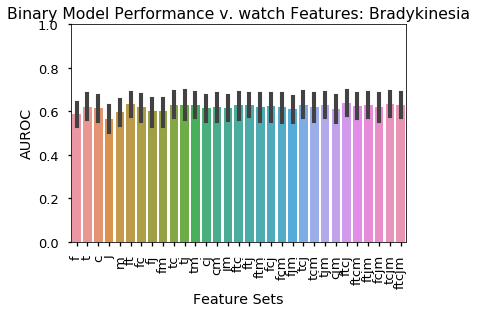

In [100]:
barplotFeatures('watch','Bradykinesia','Binary')
stats_tests('watch','Bradykinesia','Binary')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 5.169488526057966e-57
f,t,j,c,m,ftcjm
pvalue: 3.0065664718046995e-13

ftcjm, f
Ttest_relResult(statistic=-6.404954473630804, pvalue=2.3251877057090184e-05)
ftcjm, t
Ttest_relResult(statistic=-7.666402147095121, pvalue=3.5535325752105695e-06)
ftcjm, c
Ttest_relResult(statistic=-1.9177089935629226, pvalue=0.07738298318668856)
ftcjm, j
Ttest_relResult(statistic=-3.551367051969363, pvalue=0.0035471135837327927)
ftcjm, m
Ttest_relResult(statistic=-7.083949255728951, pvalue=8.244568064282004e-06)


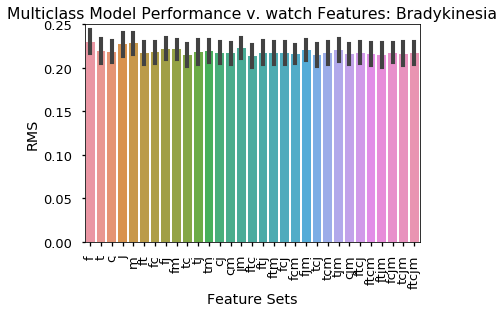

In [101]:
barplotFeatures('watch','Bradykinesia','Multiclass')
stats_tests('watch','Bradykinesia','Multiclass')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 2.8273466972509897e-40
f,t,j,c,m,ftcjm
pvalue: 0.0078120004404435665

ftcjm, f
Ttest_relResult(statistic=-0.8561662213664254, pvalue=0.4074105222362535)
ftcjm, t
Ttest_relResult(statistic=-3.8041630642022466, pvalue=0.0021899497866711)
ftcjm, c
Ttest_relResult(statistic=3.667981102590287, pvalue=0.0028382080301270008)
ftcjm, j
Ttest_relResult(statistic=0.5238851211355995, pvalue=0.6091744613152681)
ftcjm, m
Ttest_relResult(statistic=-3.3576957182615135, pvalue=0.00514402684981597)


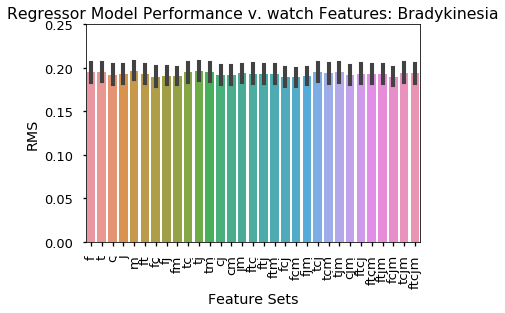

In [102]:
barplotFeatures('watch','Bradykinesia','Regressor')
stats_tests('watch','Bradykinesia','Regressor')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 4.913549054689126e-29
f,t,j,c,m,ftcjm
pvalue: 4.2425835276363614e-09

ftcjm, f
Ttest_relResult(statistic=4.357283373280962, pvalue=0.00114144646344756)
ftcjm, t
Ttest_relResult(statistic=1.8050029230751985, pvalue=0.098489939742494)
ftcjm, c
Ttest_relResult(statistic=5.631242779591054, pvalue=0.0001530219102856899)
ftcjm, j
Ttest_relResult(statistic=3.6137452250176443, pvalue=0.0040707760701365085)
ftcjm, m
Ttest_relResult(statistic=0.8157908024144905, pvalue=0.4319303500086208)


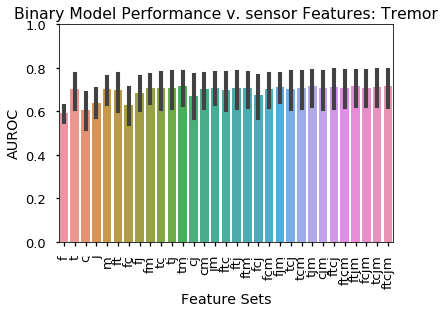

In [103]:
barplotFeatures('sensor','Tremor','Binary')
stats_tests('sensor','Tremor','Binary')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 8.906097194895458e-69
f,t,j,c,m,ftcjm
pvalue: 6.546562983963116e-14

ftcjm, f
Ttest_relResult(statistic=-3.570893216984144, pvalue=0.003846075232328544)
ftcjm, t
Ttest_relResult(statistic=-5.893765293080565, pvalue=7.323159141508633e-05)
ftcjm, c
Ttest_relResult(statistic=-2.4358245379721595, pvalue=0.03139655735073362)
ftcjm, j
Ttest_relResult(statistic=-5.043564930979698, pvalue=0.00028758868633502725)
ftcjm, m
Ttest_relResult(statistic=-9.809724200778808, pvalue=4.4057305548799193e-07)


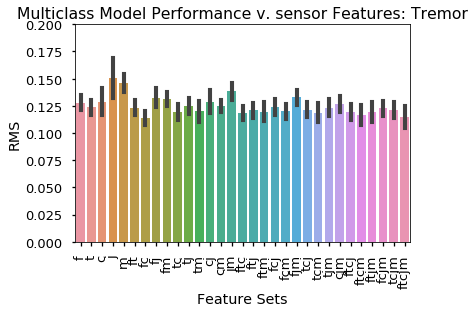

In [104]:
barplotFeatures('sensor','Tremor','Multiclass')
stats_tests('sensor','Tremor','Multiclass')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 5.218660030331608e-46
f,t,j,c,m,ftcjm
pvalue: 2.1175555596730666e-08

ftcjm, f
Ttest_relResult(statistic=-6.807450979507581, pvalue=1.8828065541660424e-05)
ftcjm, t
Ttest_relResult(statistic=-7.7068055584924355, pvalue=5.49885521147907e-06)
ftcjm, c
Ttest_relResult(statistic=-4.056460445584815, pvalue=0.0015917768386960213)
ftcjm, j
Ttest_relResult(statistic=-4.248108015498546, pvalue=0.001131090549937487)
ftcjm, m
Ttest_relResult(statistic=-15.076633720714018, pvalue=3.666374153420389e-09)


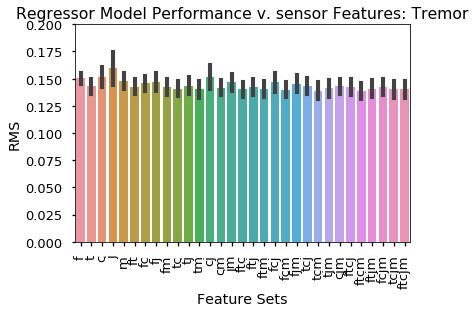

In [105]:
barplotFeatures('sensor','Tremor','Regressor')
stats_tests('sensor','Tremor','Regressor')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 1.0464594904077247e-23
f,t,j,c,m,ftcjm
pvalue: 7.1816811720361404e-06

ftcjm, f
Ttest_relResult(statistic=2.6019451072695254, pvalue=0.023142777884312345)
ftcjm, t
Ttest_relResult(statistic=-1.6025145159401066, pvalue=0.13502241540277649)
ftcjm, c
Ttest_relResult(statistic=5.153503037105223, pvalue=0.0002395936405312925)
ftcjm, j
Ttest_relResult(statistic=3.2989621823362896, pvalue=0.006352951981568172)
ftcjm, m
Ttest_relResult(statistic=2.180479433680845, pvalue=0.04985100470654528)


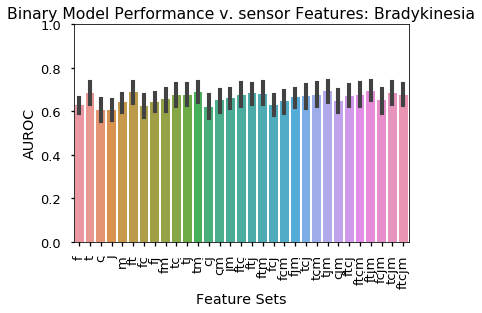

In [106]:
barplotFeatures('sensor','Bradykinesia','Binary')
stats_tests('sensor','Bradykinesia','Binary')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 5.480002033406227e-35
f,t,j,c,m,ftcjm
pvalue: 6.822754677101919e-10

ftcjm, f
Ttest_relResult(statistic=-1.7117383346874868, pvalue=0.11264326340178274)
ftcjm, t
Ttest_relResult(statistic=-2.408604035271517, pvalue=0.03299670572989949)
ftcjm, c
Ttest_relResult(statistic=-3.7259979431812074, pvalue=0.0028949952958685784)
ftcjm, j
Ttest_relResult(statistic=-1.5335150670261695, pvalue=0.15108117972836227)
ftcjm, m
Ttest_relResult(statistic=-11.49797843992827, pvalue=7.773795266251136e-08)


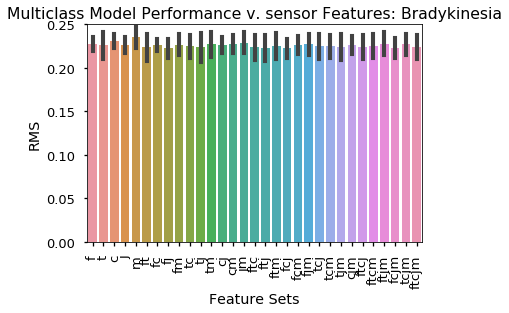

In [107]:
barplotFeatures('sensor','Bradykinesia','Multiclass')
stats_tests('sensor','Bradykinesia','Multiclass')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 1.4259586406033631e-21
f,t,j,c,m,ftcjm
pvalue: 2.8026025859182626e-05

ftcjm, f
Ttest_relResult(statistic=-1.4427561509533138, pvalue=0.17467984338227868)
ftcjm, t
Ttest_relResult(statistic=-8.155921998435492, pvalue=3.0839935042733542e-06)
ftcjm, c
Ttest_relResult(statistic=-6.247577439293316, pvalue=4.2699047868308586e-05)
ftcjm, j
Ttest_relResult(statistic=-0.204055681767295, pvalue=0.8417296959472884)
ftcjm, m
Ttest_relResult(statistic=-6.889190704028311, pvalue=1.676467917156864e-05)


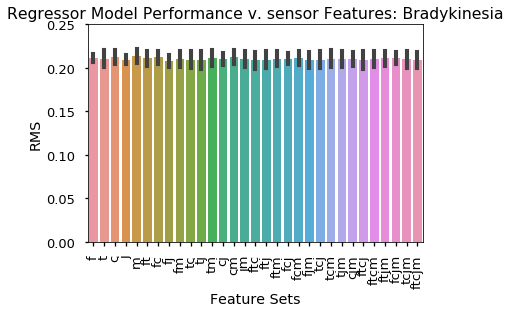

In [108]:
barplotFeatures('sensor','Bradykinesia','Regressor')
stats_tests('sensor','Bradykinesia','Regressor')